In [1]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping as lgb_early_stopping
from catboost import CatBoostClassifier
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, classification_report
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
import toad
from toad.plot import bin_plot
from toad.metrics import KS, AUC
from scipy.stats import ks_2samp
import openpyxl

In [2]:
#Загружаю датасет для модели:
def load_csv_from_zip(zip_path, csv_filename, encoding='utf_32', **kwargs):
    with zipfile.ZipFile(zip_path) as z:
        with z.open(csv_filename) as f:
            return pd.read_csv(f, encoding=encoding, **kwargs)
data = load_csv_from_zip('data_bzk_pension_202201_202403_for_modeling.zip', 'data_bzk_pension_202201_202403_for_modeling.csv', 
encoding='utf_32', dtype = {'IIN_BIN': str, 'CONTRACT_NUMBER':str}, 
parse_dates=['OPEN_DATE'])

In [3]:
print(data.columns.tolist())

['IIN_BIN', 'OPEN_DATE', 'CONTRACT_NUMBER', 'CONTRACT_AMOUNT', 'NPL91_EVER', 'BRANCH', 'CITIZENSHIP', 'TRUST_PHONE_NUMBER', 'FAMILY_STATUS', 'FACT_ADDRESS', 'EDUCATION', 'JURIDICAL_ADDRESS', 'CNT_OPEN_DEPOSIT', 'CNT_OPEN_DEPOSIT_ONLINE', 'CNT_DEPOSIT', 'CNT_CLOSE_DEPO', 'AMOUNT_REPLENISH_DEPO', 'AMOUNT_WITHDRAWAL_DEPO', 'CNT_LOAN', 'CNT_LOAN_ONLINE', 'MONTH_LOAN_PAY_AMOUNT', 'BONUS_SIZE', 'AMOUNT_OUT_MONEY', 'AMOUNT_SOC_PAYOUT', 'AMOUNT_PENSION', 'AMOUNT_CASHIN_ATM', 'CNT_MCC_CAT', 'VOLUME_NONCASH_TRANS', 'AMOUNT_CASHOUT_ATM', 'CNT_INTER_TRANSFER_HB', 'AMOUNT_INTER_TRANSFER_HB', 'CNT_TRAN_OTHER_BANK', 'AMOUNT_TRAN_OTHER_BANK', 'CNT_TRANSFER_KASPI', 'AMOUNT_TRANSFER_KASPI', 'CNT_KASPI_CARD_TRANSFER', 'CNT_INBOX_TRANSF_KASPI', 'VOLUME_INBOX_TRANSF_KASPI', 'CNT_INBOX_TRANSF_HALYK', 'VOLUME_INBOX_TRANSF_HALYK', 'CNT_PAYMENT', 'PAYMENT_AMOUNT', 'CNT_UNIQUE_MCG_USE', 'CNT_BANK_PRODUCTS_DEBIT_CARD', 'MOBILE_OS', 'MOBILE_MODEL', 'MOBILE_BRAND', 'MAU_FIREBASE', 'MAU_AUTORIZATION', 'CNT_MOBILE_P

In [4]:
#Просмотр размера датасета
data.shape

(224663, 1015)

In [5]:
#Logistic regression Part:

In [6]:
#Копирование датасета
datalog = data.copy()

In [7]:
#Удаляю переменные с Баз данных vertica и dssb для части логистической регрессии:
drop_cols = ['IIN_BIN', 'CONTRACT_NUMBER', 'CONTRACT_AMOUNT', 'BRANCH', 'CITIZENSHIP', 'TRUST_PHONE_NUMBER', 'FAMILY_STATUS', 'FACT_ADDRESS', 'EDUCATION', 'JURIDICAL_ADDRESS', 'CNT_OPEN_DEPOSIT', 'CNT_OPEN_DEPOSIT_ONLINE', 'CNT_DEPOSIT', 'CNT_CLOSE_DEPO', 'AMOUNT_REPLENISH_DEPO', 'AMOUNT_WITHDRAWAL_DEPO', 'CNT_LOAN', 'CNT_LOAN_ONLINE', 'MONTH_LOAN_PAY_AMOUNT', 'BONUS_SIZE', 'AMOUNT_OUT_MONEY', 'AMOUNT_SOC_PAYOUT', 'AMOUNT_PENSION', 'AMOUNT_CASHIN_ATM', 'CNT_MCC_CAT', 'VOLUME_NONCASH_TRANS', 'AMOUNT_CASHOUT_ATM', 'CNT_INTER_TRANSFER_HB', 'AMOUNT_INTER_TRANSFER_HB', 'CNT_TRAN_OTHER_BANK', 'AMOUNT_TRAN_OTHER_BANK', 'CNT_TRANSFER_KASPI', 'AMOUNT_TRANSFER_KASPI', 'CNT_KASPI_CARD_TRANSFER', 'CNT_INBOX_TRANSF_KASPI', 'VOLUME_INBOX_TRANSF_KASPI', 'CNT_INBOX_TRANSF_HALYK', 'VOLUME_INBOX_TRANSF_HALYK', 'CNT_PAYMENT', 'PAYMENT_AMOUNT', 'CNT_UNIQUE_MCG_USE', 'CNT_BANK_PRODUCTS_DEBIT_CARD', 'MOBILE_OS', 'MOBILE_MODEL', 'MOBILE_BRAND', 'MAU_FIREBASE', 'MAU_AUTORIZATION', 'CNT_MOBILE_PAY_HB', 'AMOUNT_MOBILE_PAY_HB', 'CNT_TRANSPORT_PAY', 'AMOUNT_TRANSPORT_PAY', 'CNT_UNIQUE_PAY_SERVICES', 'USETIME_USER_HB', 'AVG_USETIME_DAY', 'CNT_SESSIONS', 'CNT_SUCCESS_SESSIONS', 'LAST_EVENT_COUNTRY', 'LAST_EVENT_CITY', 'CNT_LOAN_PKB_WITHOUT_HB', 'LOAN_BALANCE_KASPI', 'SALARY_CATEGORY_BY_MODEL', 'FMGROUP', 'TRANSACTION_CLIENT_SEGMENT', 'ADDICTION_TO_BZK', 'ADDICTION_TO_TOVARKA', 'MCG_TOP1', 'MCG_TOP2', 'MCG_TOP3', 'WALLET_TO_INSTALLMENT', 'WALLET_TO_DEPOSIT', 'WALLET_TO_CREDIT', 'WALLET_TO_MARKET', 'CNT_BANK_PRODUCTS', 'FIRST_PRODUCT', 'PKB_RESIDENT_FL', 'PKB_ISSUE_DAY_CNT', 'PKB_EXP_DATE_DAY_CNT', 'PKB_HOME_PHONE_FL', 'PKB_DEPENDENTS_CNT', 'PKB_REQ_7D', 'PKB_REQ_30D', 'PKB_REQ_90D', 'PKB_REQ_120D', 'PKB_REQ_180D', 'PKB_REQ_360D', 'PKB_ACT_CONTRACT_CNT_KZT', 'PKB_ACT_CONTRACT_CNT_USD', 'PKB_COMPL_CONTRACT_CNT_KZT', 'PKB_COMPL_CONTRACT_CNT_USD', 'PKB_RETURN_CONTRACT_CNT_KZT', 'PKB_SUM_UNPAY_ACT', 'SUM_PKB_OVRD_ACT', 'SUM_PKB_UNPAY_COMPL', 'BINsCntdssb_ocds_paramset', 'IsCardPaysInLast2Monthsdssb_ocds_paramset', 'LivingWagedssb_ocds_paramset', 'CBHasCreditHistdssb_ocds_paramset', 'CBIssuedHBContrCntdssb_ocds_paramset', 'HBShdPayMonthsdssb_ocds_paramset', 'CB1YIncomedssb_ocds_paramset', 'CBIncomedssb_ocds_paramset', 'SalaryByWorddssb_ocds_paramset', 'FinalIncomeOlddssb_ocds_paramset', 'IsApplFormActualdssb_ocds_paramset', 'HBMPtsAmntCarddssb_ocds_paramset', 'CPPTotaldssb_ocds_paramset', 'Unicode#1WithPmntsIn45DaysPaysCntdssb_ocds_paramset', 'CBClosedContrCntdssb_ocds_paramset', 'CBCurMaxOverduedssb_ocds_paramset', 'CBOutsAmntHBCarddssb_ocds_paramset', 'CBMaxOverdueAmountdssb_ocds_paramset', 'Unicode#2WithPmntsIn45DaysPaysCntdssb_ocds_paramset', 'ReqAmntDivIncomedssb_ocds_paramset', 'HBClosedContrCntdssb_ocds_paramset', 'ColvirAccountAmountdssb_ocds_paramset', 'CBOutsAmntUnsdssb_ocds_paramset', 'CBOutsAmntdssb_ocds_paramset', 'CBoverdues_30_60dssb_ocds_paramset', 'CBShdPayMonthsdssb_ocds_paramset', 'HBMPtsAmntGdsdssb_ocds_paramset', 'HalykBankCPPOlddssb_ocds_paramset', 'TransactionInAvgSum90dssb_ocds_paramset', 'UnicodesWithPmntsIn45DaysCntdssb_ocds_paramset', 'xComPaymentsdssb_ocds_paramset', 'CBMPtsAmntdssb_ocds_paramset', 'HBOutsAmntMrtgdssb_ocds_paramset', 'dtable_Salary2dssb_ocds_paramset', 'ChildQntydssb_ocds_paramset', 'Insurancedssb_ocds_paramset', 'TransIncomedssb_ocds_paramset', 'HasDepositSCdssb_ocds_paramset', 'CBClosedHBContrCntdssb_ocds_paramset', 'CBOpenContrCnt_360dssb_ocds_paramset', 'IncomeNPAdssb_ocds_paramset', 'CBClosedKZTContrSumdssb_ocds_paramset', 'CBoverdues_60_90dssb_ocds_paramset', 'HBHasCreditHistdssb_ocds_paramset', 'HBIsRestrdssb_ocds_paramset', 'HBMPtsAmntMrtgdssb_ocds_paramset', 'HBOutsAmntUnsdssb_ocds_paramset', 'HalykBankCarddssb_ocds_paramset', 'CardPaysCountdssb_ocds_paramset', 'CardPaysCountOlddssb_ocds_paramset', 'CB3YIncomedssb_ocds_paramset', 'FinIncBgrDbldssb_ocds_paramset', 'HBOutsAmntCarddssb_ocds_paramset', 'xComPaymentsIncomedssb_ocds_paramset', 'TransactionOutAvgSum180dssb_ocds_paramset', 'CBOverdueAmntLarger1Daydssb_ocds_paramset', 'HBOpenContrCnt_360dssb_ocds_paramset', 'CBCurDelayMaxAmountdssb_ocds_paramset', 'CBPeriodFromLastContrdssb_ocds_paramset', 'HBMPtsAmntUnsdssb_ocds_paramset', 'HBOutsAmntdssb_ocds_paramset', 'HBOutsAmntGdsdssb_ocds_paramset', 'CBMaxTrmntdCntrctAmntdssb_ocds_paramset', 'HalykBankCardOlddssb_ocds_paramset', 'NBCarddssb_ocds_paramset', 'HalykBankCPPdssb_ocds_paramset', 'CPPPaysCountOlddssb_ocds_paramset', 'FinalIncomedssb_ocds_paramset', 'VerIncAmountdssb_ocds_paramset', 'MaxAmountdssb_ocds_paramset', 'xDepIncomedssb_ocds_paramset', 'TransactionInCnt180dssb_ocds_paramset', 'CBNumberOfQueries90dssb_ocds_paramset','BINsWithPmntsIn45DaysCntdssb_ocds_paramset', 'CardTotaldssb_ocds_paramset', 'CardTotalPaysCountdssb_ocds_paramset', 'CBFactPmtsdssb_ocds_paramset', 'CBMaxOverduedssb_ocds_paramset', 'CBMPtsAmntHBCarddssb_ocds_paramset', 'nbcppdssb_ocds_paramset', 'CPPPaysCountdssb_ocds_paramset', 'CB2YIncomedssb_ocds_paramset', 'dtable_Salary3dssb_ocds_paramset', 'ColvirDepositAmountdssb_ocds_paramset', 'TransactionInOutDiff30dssb_ocds_paramset', 'CBOpenContrCnt_180dssb_ocds_paramset', 'CPPTotalPaysCountdssb_ocds_paramset', 'CBFactPmts1Ydssb_ocds_paramset', 'CBPeriodFromFirstContrdssb_ocds_paramset', 'HBMPtsAmntdssb_ocds_paramset', 'kdndssb_ocds_paramset', 'xCarIncomedssb_ocds_paramset', 'HBOpenContrCnt_180dssb_ocds_paramset','cred_cnt', 'cred_cnt_active', 'cred_cnt_non_active', 'cred_cnt_repayment_day_1_bzk', 'cred_cnt_repayment_day_2_bzk', 'cred_cnt_repayment_day_3_bzk', 'cred_day_cnt_min_open_date', 'cred_day_cnt_min_open_date_act', 'cred_given_sum', 'cred_remain_loan_sum', 'cred_paid_percent_loan_sum', 'cred_remain_loan_sum_30d', 'cred_paid_percent_loan_sum_30d', 'cred_remain_loan_sum_90d', 'cred_paid_percent_loan_sum_90d', 'cred_remain_loan_sum_180d', 'cred_paid_percent_loan_sum_180d', 'cred_sum_avto', 'cred_sum_act_avto', 'cred_cnt_avto', 'cred_cnt_act_avto', 'cred_annuity_sum_avto', 'cred_annuity_sum_act_avto', 'cred_eff_rate_act_avto', 'cred_repaid_early_sum_last360d_avto', 'cred_repaid_early_cnt_avto', 'cred_sum_bnpl', 'cred_sum_act_bnpl', 'cred_cnt_bnpl', 'cred_cnt_act_bnpl', 'cred_annuity_sum_bnpl', 'cred_annuity_sum_act_bnpl', 'cred_dpd_cnt_bnpl', 'cred_dpd_sum_10d_bnpl', 'cred_dpd_sum_30d_bnpl', 'cred_dpd_cnt_10d_bnpl', 'cred_eff_rate_act_bnpl', 'cred_repaid_early_cnt_in90d_bnpl', 'cred_repaid_early_sum_in90d_bnpl', 'cred_repaid_early_sum_last360d_bnpl', 'cred_repaid_early_sum_in360d_bnpl', 'cred_repaid_early_cnt_bnpl', 'cred_sum_bzk', 'cred_sum_act_bzk', 'cred_cnt_bzk', 'cred_cnt_act_bzk', 'cred_annuity_sum_bzk', 'cred_annuity_sum_act_bzk', 'cred_dpd_cnt_bzk', 'cred_dpd_cnt_10d_bzk', 'cred_dpd_cnt_30d_bzk', 'cred_dpd_sum_10d_bzk', 'cred_dpd_sum_30d_bzk', 'cred_fstpd_cnt_90d_bzk', 'cred_repaid_early_sum_last90d_bzk', 'cred_repaid_early_cnt_last90d_bzk', 'cred_eff_rate_act_bzk', 'cred_insur_cnt_bzk', 'cred_repaid_early_cnt_bzk', 'cred_sum_ipoteka', 'cred_sum_act_ipoteka', 'cred_cnt_ipoteka', 'cred_cnt_act_ipoteka', 'cred_annuity_sum_ipoteka', 'cred_annuity_sum_act_ipoteka', 'cred_dpd_cnt_ipoteka', 'cred_dpd_cnt_10d_ipoteka', 'cred_eff_rate_act_ipoteka', 'cred_day_cnt_max_open_date_ipoteka', 'cred_day_cnt_max_end_date_ipoteka', 'cred_repaid_early_cnt_ipoteka', 'cred_req_bzk_cnt', 'cred_req_ipoteka_cnt', 'cred_req_bnpl_cnt', 'cred_req_bnpl_qr_cnt', 'cred_req_avto_cnt', 'cred_req_bzk_amount', 'cred_req_ipoteka_amount', 'cred_req_bnpl_amount', 'cred_req_bnpl_qr_amount', 'cred_req_avto_amount', 'cred_req_bzk_cnt_30d', 'cred_req_ipoteka_cnt_30d', 'cred_req_bnpl_cnt_30d', 'cred_req_bnpl_qr_cnt_30d', 'cred_req_avto_cnt_30d', 'cred_req_bzk_cnt_90d', 'cred_req_ipoteka_cnt_90d', 'cred_req_bnpl_cnt_90d', 'cred_req_bnpl_qr_cnt_90d', 'cred_req_avto_cnt_90d', 'cred_req_bzk_sum_7d', 'cred_req_bzk_sum_7d_appr', 'cred_req_bzk_cnt_7d_issued', 'cred_req_bzk_cnt_7d_issued_flag', 'cred_req_bzk_cnt_30d_issued_flag', 'cred_req_bzk_sum_7d_otkaz', 'cred_req_bzk_sum_30d_otkaz', 'cred_req_ipoteka_sum_7d', 'cred_req_bnpl_sum_7d', 'cred_req_bnpl_qr_sum_7d', 'cred_req_avto_sum_7d', 'cred_req_bzk_sum_90d', 'cred_req_ipoteka_sum_90d', 'cred_req_bnpl_sum_90d', 'cred_req_bnpl_qr_sum_90d', 'cred_req_avto_sum_90d', 'cred_req_bzk_sum_180d', 'cred_req_ipoteka_sum_180d', 'cred_req_bnpl_sum_180d', 'cred_req_bnpl_qr_sum_180d', 'cred_req_avto_sum_180d', 'cred_req_bzk_cnt_90d_issued', 'cred_req_bnpl_cnt_90d_issued', 'cred_req_bnpl_qr_cnt_90d_issued', 'cred_req_avto_cnt_90d_issued', 'cred_req_bzk_cnt_180d_issued', 'cred_req_bnpl_cnt_180d_issued', 'cred_req_bnpl_qr_cnt_180d_issued', 'cred_req_avto_cnt_180d_issued', 'cred_req_bzk_cnt_days_last', 'cred_req_ipoteka_cnt_days_last', 'cred_req_bnpl_cnt_days_last', 'cred_req_bnpl_qr_cnt_days_last', 'cred_req_avto_cnt_days_last', 'depo_in_30d', 'depo_in_lcy_30d', 'depo_in_usd_30d', 'depo_in_90d', 'depo_in_lcy_90d', 'depo_in_usd_90d', 'depo_in_360d', 'depo_in_lcy_360d', 'depo_in_usd_360d', 'depo_out_30d', 'depo_out_lcy_30d', 'depo_out_usd_30d', 'depo_out_euro_30d', 'depo_out_90d', 'depo_out_lcy_90d', 'depo_out_usd_90d', 'depo_out_euro_90d', 'depo_out_360d', 'depo_out_lcy_360d', 'depo_out_usd_360d', 'depo_out_euro_360d', 'depo_saldo_30d', 'depo_saldo_lcy_30d', 'depo_saldo_usd_30d', 'depo_saldo_euro_30d', 'depo_saldo_90d', 'depo_saldo_lcy_90d', 'depo_saldo_usd_90d', 'depo_saldo_euro_90d', 'depo_saldo_360d', 'depo_saldo_lcy_360d', 'depo_saldo_usd_360d', 'depo_saldo_euro_360d', 'depo_reward_30d', 'depo_reward_lcy_30d', 'depo_reward_usd_30d', 'depo_reward_euro_30d', 'depo_reward_90d', 'depo_reward_lcy_90d', 'depo_reward_usd_90d', 'depo_reward_euro_90d', 'depo_reward_360d', 'depo_reward_lcy_360d', 'depo_reward_usd_360d', 'depo_reward_euro_360d', 'depo_cnt', 'depo_cnt_lcy', 'depo_cnt_usd', 'depo_cnt_euro', 'depo_sum', 'depo_sum_lcy', 'depo_sum_usd', 'depo_sum_euro', 'depo_sum_30d', 'depo_sum_lcy_30d', 'depo_sum_usd_30d', 'depo_sum_euro_30d', 'depo_sum_90d', 'depo_sum_lcy_90d', 'depo_sum_usd_90d', 'depo_sum_euro_90d', 'depo_sum_360d', 'depo_sum_lcy_360d', 'depo_sum_usd_360d', 'depo_sum_euro_360d', 'trans_mcg_cash_services_amnt_30d', 'trans_mcg_cash_services_avg_30d', 'trans_mcg_cash_services_count_30d', 'trans_mcg_fuel_service_station_amnt_30d', 'trans_mcg_fuel_service_station_avg_30d', 'trans_mcg_fuel_service_station_count_30d', 'trans_mcg_gambling_amnt_30d', 'trans_mcg_gambling_avg_30d', 'trans_mcg_gambling_count_30d', 'trans_mcg_pharmacy_amnt_30d', 'trans_mcg_pharmacy_avg_30d', 'trans_mcg_pharmacy_count_30d', 'trans_mcg_restaurants_amnt_30d', 'trans_mcg_restaurants_avg_30d', 'trans_mcg_restaurants_count_30d', 'trans_mcg_supermarkets_amnt_30d', 'trans_mcg_supermarkets_avg_30d', 'trans_mcg_supermarkets_count_30d', 'trans_mcg_telecommunication_amnt_30d', 'trans_mcg_telecommunication_avg_30d', 'trans_mcg_telecommunication_count_30d', 'trans_mcg_transportation_amnt_30d', 'trans_mcg_transportation_avg_30d', 'trans_mcg_transportation_count_30d', 'trans_mcg_utilities_amnt_30d', 'trans_mcg_utilities_avg_30d', 'trans_mcg_utilities_count_30d', 'trans_mcg_cash_services_amnt_90d', 'trans_mcg_cash_services_avg_90d', 'trans_mcg_cash_services_count_90d', 'trans_mcg_fuel_service_station_amnt_90d', 'trans_mcg_fuel_service_station_avg_90d', 'trans_mcg_fuel_service_station_count_90d', 'trans_mcg_gambling_amnt_90d', 'trans_mcg_gambling_avg_90d', 'trans_mcg_gambling_count_90d', 'trans_mcg_pharmacy_amnt_90d', 'trans_mcg_pharmacy_avg_90d', 'trans_mcg_pharmacy_count_90d', 'trans_mcg_restaurants_amnt_90d', 'trans_mcg_restaurants_avg_90d', 'trans_mcg_restaurants_count_90d', 'trans_mcg_supermarkets_amnt_90d', 'trans_mcg_supermarkets_avg_90d', 'trans_mcg_supermarkets_count_90d', 'trans_mcg_telecommunication_amnt_90d', 'trans_mcg_telecommunication_avg_90d', 'trans_mcg_telecommunication_count_90d', 'trans_mcg_transportation_amnt_90d', 'trans_mcg_transportation_avg_90d', 'trans_mcg_transportation_count_90d', 'trans_mcg_utilities_amnt_90d', 'trans_mcg_utilities_avg_90d', 'trans_mcg_utilities_count_90d', 'pkb_bvu_report_id', 'pkb_bvu_total_loan_cnt', 'pkb_bvu_total_monthly_payment', 'pkb_bvu_total_credit_sum', 'pkb_bvu_total_od', 'pkb_bvu_max_delay_cnt_2y_all_cred', 'pkb_bvu_max_delay_amount_2y_all_cred', 'pkb_bvu_max_nominal', 'pkb_bvu_loan_cnt_lender_altyn', 'pkb_bvu_loan_cnt_lender_rbk', 'pkb_bvu_loan_cnt_lender_jusan', 'pkb_bvu_loan_cnt_lender_forte', 'pkb_bvu_loan_cnt_lender_kaspi', 'pkb_bvu_loan_cnt_lender_other', 'pkb_bvu_loan_cnt_lender_vtb', 'pkb_bvu_loan_cnt_lender_homecredit', 'pkb_bvu_loan_cnt_lender_centrcredit', 'pkb_bvu_loan_cnt_lender_bereke', 'pkb_bvu_loan_cnt_lender_eurasia', 'pkb_bvu_loan_cnt_lender_kjk', 'pkb_bvu_loan_cnt_lender_mfo', 'pkb_bvu_loan_cnt_lender_kmf', 'pkb_bvu_loan_cnt_lender_mycar', 'pkb_bvu_loan_cnt_lender_otbasy', 'pkb_bvu_loan_cnt_lender_freedom', 'pkb_bvu_loan_cnt_lender_shinkhan', 'pkb_bvu_monthly_payment_lender_altyn', 'pkb_bvu_monthly_payment_lender_rbk', 'pkb_bvu_monthly_payment_lender_jusan', 'pkb_bvu_monthly_payment_lender_forte', 'pkb_bvu_monthly_payment_lender_kaspi', 'pkb_bvu_monthly_payment_lender_other', 'pkb_bvu_monthly_payment_lender_homecredit', 'pkb_bvu_monthly_payment_lender_centrcredit', 'pkb_bvu_monthly_payment_lender_bereke', 'pkb_bvu_monthly_payment_lender_eurasia', 'pkb_bvu_monthly_payment_lender_kjk', 'pkb_bvu_monthly_payment_lender_mfo', 'pkb_bvu_monthly_payment_lender_kmf', 'pkb_bvu_monthly_payment_lender_mycar', 'pkb_bvu_monthly_payment_lender_otbasy', 'pkb_bvu_monthly_payment_lender_freedom', 'pkb_bvu_monthly_payment_lender_shinkhan', 'pkb_bvu_credit_sum_lender_altyn', 'pkb_bvu_credit_sum_lender_rbk', 'pkb_bvu_credit_sum_lender_jusan', 'pkb_bvu_credit_sum_lender_forte', 'pkb_bvu_credit_sum_lender_kaspi', 'pkb_bvu_credit_sum_lender_other', 'pkb_bvu_credit_sum_lender_vtb', 'pkb_bvu_credit_sum_lender_homecredit', 'pkb_bvu_credit_sum_lender_centrcredit', 'pkb_bvu_credit_sum_lender_bereke', 'pkb_bvu_credit_sum_lender_eurasia', 'pkb_bvu_credit_sum_lender_kjk', 'pkb_bvu_credit_sum_lender_mfo', 'pkb_bvu_credit_sum_lender_kmf', 'pkb_bvu_credit_sum_lender_mycar', 'pkb_bvu_credit_sum_lender_otbasy', 'pkb_bvu_credit_sum_lender_freedom', 'pkb_bvu_credit_sum_lender_shinkhan', 'pkb_bvu_od_lender_altyn', 'pkb_bvu_od_lender_rbk', 'pkb_bvu_od_lender_jusan', 'pkb_bvu_od_lender_forte', 'pkb_bvu_od_lender_kaspi', 'pkb_bvu_od_lender_other', 'pkb_bvu_od_lender_vtb', 'pkb_bvu_od_lender_homecredit', 'pkb_bvu_od_lender_centrcredit', 'pkb_bvu_od_lender_bereke', 'pkb_bvu_od_lender_eurasia', 'pkb_bvu_od_lender_kjk', 'pkb_bvu_od_lender_mfo', 'pkb_bvu_od_lender_kmf', 'pkb_bvu_od_lender_mycar', 'pkb_bvu_od_lender_otbasy', 'pkb_bvu_od_lender_freedom', 'pkb_bvu_od_lender_shinkhan', 'pkb_bvu_max_delay_day_cnt_2y_lender_altyn', 'pkb_bvu_max_delay_day_cnt_2y_lender_rbk', 'pkb_bvu_max_delay_day_cnt_2y_lender_jusan', 'pkb_bvu_max_delay_day_cnt_2y_lender_forte', 'pkb_bvu_max_delay_day_cnt_2y_lender_kaspi', 'pkb_bvu_max_delay_day_cnt_2y_lender_other', 'pkb_bvu_max_delay_day_cnt_2y_lender_homecredit', 'pkb_bvu_max_delay_day_cnt_2y_lender_centrcredit', 'pkb_bvu_max_delay_day_cnt_2y_lender_bereke', 'pkb_bvu_max_delay_day_cnt_2y_lender_eurasia', 'pkb_bvu_max_delay_day_cnt_2y_lender_kjk', 'pkb_bvu_max_delay_day_cnt_2y_lender_mfo', 'pkb_bvu_max_delay_day_cnt_2y_lender_kmf', 'pkb_bvu_max_delay_day_cnt_2y_lender_mycar', 'pkb_bvu_max_delay_day_cnt_2y_lender_otbasy', 'pkb_bvu_max_delay_day_cnt_2y_lender_freedom', 'pkb_bvu_max_delay_amount_2y_lender_altyn', 'pkb_bvu_max_delay_amount_2y_lender_rbk', 'pkb_bvu_max_delay_amount_2y_lender_jusan', 'pkb_bvu_max_delay_amount_2y_lender_forte', 'pkb_bvu_max_delay_amount_2y_lender_kaspi', 'pkb_bvu_max_delay_amount_2y_lender_other', 'pkb_bvu_max_delay_amount_2y_lender_homecredit', 'pkb_bvu_max_delay_amount_2y_lender_centrcredit', 'pkb_bvu_max_delay_amount_2y_lender_bereke', 'pkb_bvu_max_delay_amount_2y_lender_eurasia', 'pkb_bvu_max_delay_amount_2y_lender_kjk', 'pkb_bvu_max_delay_amount_2y_lender_mfo', 'pkb_bvu_max_delay_amount_2y_lender_kmf', 'pkb_bvu_max_delay_amount_2y_lender_mycar', 'pkb_bvu_max_delay_amount_2y_lender_otbasy', 'pkb_bvu_max_delay_amount_2y_lender_freedom', 'pkb_bvu_nominal_rate_lender_altyn', 'pkb_bvu_nominal_rate_lender_rbk', 'pkb_bvu_nominal_rate_lender_jusan', 'pkb_bvu_nominal_rate_lender_forte', 'pkb_bvu_nominal_rate_lender_kaspi', 'pkb_bvu_nominal_rate_lender_other', 'pkb_bvu_nominal_rate_lender_vtb', 'pkb_bvu_nominal_rate_lender_homecredit', 'pkb_bvu_nominal_rate_lender_centrcredit', 'pkb_bvu_nominal_rate_lender_bereke', 'pkb_bvu_nominal_rate_lender_eurasia', 'pkb_bvu_nominal_rate_lender_kjk', 'pkb_bvu_nominal_rate_lender_mfo', 'pkb_bvu_nominal_rate_lender_kmf', 'pkb_bvu_nominal_rate_lender_mycar', 'pkb_bvu_nominal_rate_lender_otbasy', 'pkb_bvu_nominal_rate_lender_freedom', 'pkb_bvu_nominal_rate_lender_shinkhan', 'pkb_bvu_loan_cnt_pledge_7_20_25', 'pkb_bvu_loan_cnt_pledge_baspana', 'pkb_bvu_loan_cnt_pledge_bzk_0', 'pkb_bvu_loan_cnt_pledge_bzk_1', 'pkb_bvu_loan_cnt_pledge_bzk', 'pkb_bvu_loan_cnt_pledge_vn_ipoteka', 'pkb_bvu_loan_cnt_pledge_vn_avto', 'pkb_bvu_loan_cnt_pledge_zalog', 'pkb_bvu_loan_cnt_pledge_cc', 'pkb_bvu_loan_cnt_pledge_cc_0', 'pkb_bvu_loan_cnt_pledge_cc_1', 'pkb_bvu_monthly_payment_pledge_7_20_25', 'pkb_bvu_monthly_payment_pledge_baspana', 'pkb_bvu_monthly_payment_pledge_bzk_0', 'pkb_bvu_monthly_payment_pledge_bzk_1', 'pkb_bvu_monthly_payment_pledge_bzk', 'pkb_bvu_monthly_payment_pledge_vn_ipoteka', 'pkb_bvu_monthly_payment_pledge_vn_avto', 'pkb_bvu_monthly_payment_pledge_zalog', 'pkb_bvu_monthly_payment_pledge_cc', 'pkb_bvu_monthly_payment_pledge_cc_0', 'pkb_bvu_monthly_payment_pledge_cc_1', 'pkb_bvu_credit_sum_pledge_7_20_25', 'pkb_bvu_credit_sum_pledge_baspana', 'pkb_bvu_credit_sum_pledge_bzk_0', 'pkb_bvu_credit_sum_pledge_bzk_1', 'pkb_bvu_credit_sum_pledge_bzk', 'pkb_bvu_credit_sum_pledge_vn_ipoteka', 'pkb_bvu_credit_sum_pledge_vn_avto', 'pkb_bvu_credit_sum_pledge_zalog', 'pkb_bvu_credit_sum_pledge_cc', 'pkb_bvu_credit_sum_pledge_cc_0', 'pkb_bvu_credit_sum_pledge_cc_1', 'pkb_bvu_od_pledge_7_20_25', 'pkb_bvu_od_pledge_baspana', 'pkb_bvu_od_pledge_bzk_0', 'pkb_bvu_od_pledge_bzk_1', 'pkb_bvu_od_pledge_bzk', 'pkb_bvu_od_pledge_vn_ipoteka', 'pkb_bvu_od_pledge_vn_avto', 'pkb_bvu_od_pledge_zalog', 'pkb_bvu_od_pledge_cc', 'pkb_bvu_od_pledge_cc_0', 'pkb_bvu_od_pledge_cc_1', 'pkb_bvu_max_delay_day_cnt_2y_pledge_baspana', 'pkb_bvu_max_delay_day_cnt_2y_pledge_bzk_0', 'pkb_bvu_max_delay_day_cnt_2y_pledge_bzk_1', 'pkb_bvu_max_delay_day_cnt_2y_pledge_bzk', 'pkb_bvu_max_delay_day_cnt_2y_pledge_vn_ipoteka', 'pkb_bvu_max_delay_day_cnt_2y_pledge_vn_avto', 'pkb_bvu_max_delay_day_cnt_2y_pledge_zalog', 'pkb_bvu_max_delay_day_cnt_2y_pledge_cc', 'pkb_bvu_max_delay_day_cnt_2y_pledge_cc_0', 'pkb_bvu_max_delay_day_cnt_2y_pledge_cc_1', 'pkb_bvu_max_delay_amount_2y_pledge_baspana', 'pkb_bvu_max_delay_amount_2y_pledge_bzk_0', 'pkb_bvu_max_delay_amount_2y_pledge_bzk_1', 'pkb_bvu_max_delay_amount_2y_pledge_bzk', 'pkb_bvu_max_delay_amount_2y_pledge_vn_ipoteka', 'pkb_bvu_max_delay_amount_2y_pledge_vn_avto', 'pkb_bvu_max_delay_amount_2y_pledge_zalog', 'pkb_bvu_max_delay_amount_2y_pledge_cc', 'pkb_bvu_max_delay_amount_2y_pledge_cc_0', 'pkb_bvu_max_delay_amount_2y_pledge_cc_1', 'pkb_bvu_nominal_rate_pledge_7_20_25', 'pkb_bvu_nominal_rate_pledge_baspana', 'pkb_bvu_nominal_rate_pledge_bzk_1', 'pkb_bvu_nominal_rate_pledge_bzk', 'pkb_bvu_nominal_rate_pledge_vn_ipoteka', 'pkb_bvu_nominal_rate_pledge_vn_avto', 'pkb_bvu_nominal_rate_pledge_zalog', 'pkb_bvu_nominal_rate_pledge_cc', 'pkb_bvu_nominal_rate_pledge_cc_1', 'hb_mpayment_sum_bzk', 'hb_mpayment_sum_bnpl', 'hb_mpayment_sum_avto', 'hb_mpayment_sum_ipoteka', 'hb_total_mpayment', 'kdn', 'pkb_gender_fl', 'pkb_education', 'pkb_marital_status', 'pkb_subj_classif', 'pkb_subj_status', 'pkb_receivetime_hour', 'pkb_receivetime_day_cnt', 'pkb_req_7d', 'pkb_req_30d', 'pkb_req_90d', 'pkb_req_120d', 'pkb_req_180d', 'pkb_req_360d', 'pkb_act_contract_cnt_kzt', 'pkb_compl_contract_cnt_kzt', 'pkb_return_contract_cnt_kzt', 'pkb_sum_unpay_act', 'pkb_sum_ovrd_act', 'salary_fl', 'card_purchase_frequency', 'card_purchase_sum', 'one_product', 'loan_cnt', 'safe_cnt', 'account_cnt', 'credit_card_cnt', 'debit_card_cnt', 'homebank_fl', 'is_active', 'is_mau', 'is_beznal', 'is_obnal', 'beznal_transaction_cnt', 'beznal_amount', 'obnal_transaction_cnt', 'obnal_amount', 'is_retail', 'retail_transaction_cnt', 'retail_amount', 'session_cnt', 'deposit_cnt', 'deposit_amount', 'trans_in_pens_amnt_30d', 'trans_in_pens_amnt_avg_30d', 'trans_in_pens_count_30d', 'trans_in_posobiye_amnt_30d', 'trans_in_posobiye_amnt_avg_30d', 'trans_in_posobiye_count_30d', 'trans_in_p2p_amount_30d', 'trans_in_p2p_amount_avg_30d', 'trans_in_p2p_count_30d', 'trans_in_depo_amnt_30d', 'trans_in_depo_amnt_avg_30d', 'trans_in_depo_count_30d', 'trans_in_zp_amnt_30d', 'trans_in_zp_amnt_avg_30d', 'trans_in_zp_count_30d', 'trans_in_pens_amnt_90d', 'trans_in_pens_amnt_avg_90d', 'trans_in_pens_count_90d', 'trans_in_posobiye_amnt_90d', 'trans_in_posobiye_amnt_avg_90d', 'trans_in_posobiye_count_90d', 'trans_in_p2p_amount_90d', 'trans_in_p2p_amount_avg_90d', 'trans_in_p2p_count_90d', 'trans_in_depo_amnt_90d', 'trans_in_depo_amnt_avg_90d', 'trans_in_depo_count_90d', 'trans_in_zp_amnt_90d', 'trans_in_zp_amnt_avg_90d', 'trans_in_zp_count_90d', 'trans_in_zp_amnt_45d', 'trans_in_zp_count_45d', 'trans_in_gtsvp_salary', 'trans_in_zp_avg_6_months', 'trans_in_pens_avg_6_months', 'trans_in_pens_amnt_45d', 'trans_in_pens_count_45d', 'trans_in_client_type', 'trans_in_final_income', 'trans_out_cash_amount_30d', 'trans_out_cash_amount_avg_30d', 'trans_out_cash_count_30d', 'trans_out_cash_days_since_last_30d', 'trans_out_cash_months_active_30d', 'trans_out_ecom_amount_30d', 'trans_out_ecom_amount_avg_30d', 'trans_out_ecom_count_30d', 'trans_out_ecom_days_since_last_30d', 'trans_out_ecom_months_active_30d', 'trans_out_p2p_amount_30d', 'trans_out_p2p_amount_avg_30d', 'trans_out_p2p_count_30d', 'trans_out_p2p_days_since_last_30d', 'trans_out_p2p_months_active_30d', 'trans_out_pos_amnt_30d', 'trans_out_pos_amnt_avg_30d', 'trans_out_pos_count_30d', 'trans_out_pos_days_since_last_30d', 'trans_out_pos_months_active_30d', 'trans_out_qr_amnt_30d', 'trans_out_qr_avg_30d', 'trans_out_qr_count_30d', 'trans_out_qr_days_since_last_30d', 'trans_out_qr_months_active_30d', 'trans_out_cash_amount_90d', 'trans_out_cash_amount_avg_90d', 'trans_out_cash_count_90d', 'trans_out_cash_days_since_last_90d', 'trans_out_cash_months_active_90d', 'trans_out_ecom_amount_90d', 'trans_out_ecom_amount_avg_90d', 'trans_out_ecom_count_90d', 'trans_out_ecom_days_since_last_90d', 'trans_out_ecom_months_active_90d', 'trans_out_p2p_amount_90d', 'trans_out_p2p_amount_avg_90d', 'trans_out_p2p_count_90d', 'trans_out_p2p_days_since_last_90d', 'trans_out_p2p_months_active_90d', 'trans_out_pos_amnt_90d', 'trans_out_pos_amnt_avg_90d', 'trans_out_pos_count_90d', 'trans_out_pos_days_since_last_90d', 'trans_out_pos_months_active_90d', 'trans_out_qr_amnt_90d', 'trans_out_qr_avg_90d', 'trans_out_qr_count_90d', 'trans_out_qr_days_since_last_90d', 'trans_out_qr_months_active_90d']
datalog.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [8]:
#Функция определения переменных с количеством уникальных значений > 2000 для последующего удаления из датасета в связи с невозможностью внедрения в кредитный конвейер FICO
def identify_high_cardinality_columns(df, threshold=20000):
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns
    high_card_cols = [
        col for col in non_numeric_cols
        if df[col].nunique(dropna=False) > threshold
    ]
    return high_card_cols

In [9]:
cols = identify_high_cardinality_columns(datalog)
print(cols)

['ColvirDepositAccount_DepoRetAcc', 'client_id', 'ColvirDepositAccount_AccCode', 'ColvirDepositAccount_CodeAcc']


In [10]:
#Удаление переменных - уникальных id:
drop_cols = ['ColvirDepositAccount_DepoRetAcc', 'client_id', 'ColvirDepositAccount_AccCode', 'ColvirDepositAccount_CodeAcc']
datalog.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [11]:
#Просмотр размера датасета 
datalog.shape

(224663, 242)

In [12]:
#Просмотр распределения целевой переменной
datalog['NPL91_EVER'].value_counts()

NPL91_EVER
0    218039
1      6624
Name: count, dtype: int64

In [13]:
#Выбор переменных по iv, % пустых значений и корреляции, FinalIncomeParametrSet отделяется т.к. аналог переменной FinalIncomeOld
datalog, dropped = toad.selection.select(datalog, target = 'NPL91_EVER', empty = 0.9, iv = 0.05, corr = 0.7, return_drop=True, exclude = ['FinalIncomeParametrSet'])
print(datalog.shape)

(224663, 47)


In [14]:
#after looking feature importance, bins and scorepoints
drop_cols = ['PKB_REQ_7DAY', 'PKB_REQ_30DAY', 'CBCreditHistoryParametrSet', 'FinalCreditHistoryParametrSet', 'KDNParametrSet', 'nationality_nameRu', 'MonthlyPaymentParametrSet',
'CNT_DAY_GR_30_Sum', 'dtable_Salary2ParametrSet', 'FinalIncomeOldParametrSet', 'HBShdPayMonthsParametrSet', 'InternalDelinquencyAccounts_Table_shdAmount2', 
'CBShdPayMonthsParametrSet', 'NBCardParametrSet', 'IncomeNPAParametrSet', 'DAYS_BETWEEN_FIRST', 'CBClosedContrCntParametrSet', 'MAX_OUSTAND_SUM_CUR', 
'CBMaxTrmntdCntrctAmntParametrSet', 'SUM_ZAKRYTYE', 'COUNT_OTKRYTYE_30', 'DEISTV_HALYK', 'COUNT_OTKRYTYE_180', 'birthPlace_region_nameRu', 
'regAddress_region_nameRu',  'PoVClient_Client360dDebitCardDebitTransactionAmount', 'SUM_OTKRYTYE_90', 'MAX_SUM_OUTSTND', 
'CBPeriodFromLastContrParametrSet', 'HBMPtsAmntUnsParametrSet', 'FinalIncomeParametrSet']
datalog.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [15]:
#Просмотр размера датасета 
datalog.shape

(224663, 16)

In [16]:
#Разделение на валидационную и моделируемую выборки
datalogmodel = datalog[datalog['OPEN_DATE'] <= '2023-12-31']
del datalogmodel['OPEN_DATE']
datalogvalid = datalog[datalog['OPEN_DATE'] >= '2024-01-01']
del datalogvalid['OPEN_DATE']
print(datalogmodel.shape, datalogvalid.shape)

(203279, 15) (21384, 15)


In [17]:
#разделение датасета на трейн и тест
X_1 = datalogmodel.drop('NPL91_EVER', axis = 1)
y_1 = datalogmodel['NPL91_EVER']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.3, random_state = 42)

In [18]:
#Бинирование данных c разделением пустых значений:
combiner1 = toad.transform.Combiner()
combiner1.fit(X_train1, y_train1, method = 'chi', min_samples = 0.05, empty_separate = True)
train_selected_bin1 = combiner1.transform(X_train1)
test_selected_bin1 = combiner1.transform(X_test1)

In [19]:
#Просмотр бинов в каждой переменной:
print("Bins for each feature:")
for feature in combiner1.export():
    print(f"{feature}:{combiner1.export()[feature]}")

Bins for each feature:
gender_nameRu:[['Женский'], ['Мужской']]
LastApprovedOfferSet_Payment:[4976.5, 29038.8, nan]
CBFactPmtsParametrSet:[1, 24, 39, 69, 113]
AgeParametrSet:[60.17, 63.17, 68.25]
PoVClient_ClientCountWithoutOverduePay:[7.0, 36.0, 49.0, nan]
CBMaxOverdueParametrSet:[4]
CBCreditHistoryFromServParametrSet:[['Положительная'], ['Приемлемая 2', 'Приемлемая 1', 'Удовлетворительная', 'Отрицательная']]
PKB_REQ_360DAY:[3.0, 6.0, 8.0, 14.0, nan]
SUM_OSTATOK:[230836.48, 476416.21, nan]
MAX_OUSTAND_DAY_CNT:[12.0, 28.0, nan]
CNT_DAY_GR_0_Sum:[1.0, 2.0, 4.0, 11.0, nan]
educationtypedmparse2:[['nan', 'ВЫСШЕЕ'], ['УЧЁНАЯ СТЕПЕНЬ', 'СРЕДНЕЕ СПЕЦИАЛЬНОЕ', 'НЕПОЛНОЕ СРЕДНЕЕ'], ['СРЕДНЕЕ']]
low_rod_income:[65110.5, nan]
KDN:[0.3279432718115245, 0.459430902525749, nan]


In [20]:
#Редактирование бинов:
custom_bins = {'low_rod_income':[65000, np.nan],
               'gender_nameRu':[['Женский'], ['Мужской']], 
               'LastApprovedOfferSet_Payment':[5000, 30000, np.nan], 
               'CBFactPmtsParametrSet':[13, 24, 40, 100],
               'AgeParametrSet':[58, 63, 68],
               'PoVClient_ClientCountWithoutOverduePay':[7, 30, 70, np.nan], 
               'CBMaxOverdueParametrSet':[10],
               'CBCreditHistoryFromServParametrSet':[['Положительная'], ['Приемлемая 2', 'Приемлемая 1', 'Удовлетворительная'], ['Отрицательная']],
               'PKB_REQ_360DAY':[3, 8, 16, np.nan], 
               'SUM_OSTATOK':[100000, 500000, np.nan], 
               'MAX_OUSTAND_DAY_CNT':[12, 28, np.nan], 
               'CNT_DAY_GR_0_Sum':[1, 4, 11, np.nan],
               'educationtypedmparse2':[['ВЫСШЕЕ', 'УЧЁНАЯ СТЕПЕНЬ'], ['СРЕДНЕЕ СПЕЦИАЛЬНОЕ'], ['nan', 'СРЕДНЕЕ', 'НЕПОЛНОЕ СРЕДНЕЕ']],
               'KDN':[0.1, 0.4, np.nan], 
}
combiner1.set_rules(custom_bins)
train_selected_bin1 = combiner1.transform(X_train1)
test_selected_bin1 = combiner1.transform(X_test1)

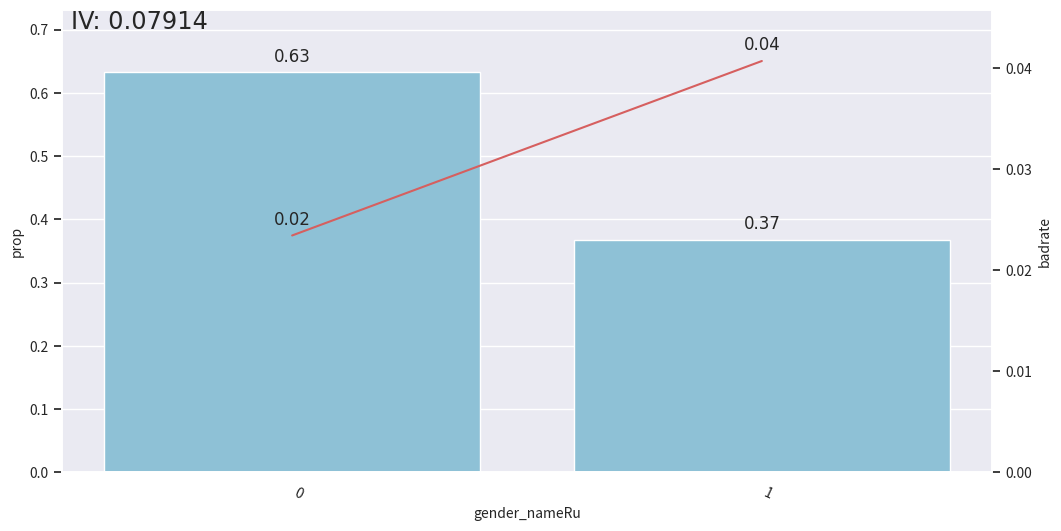

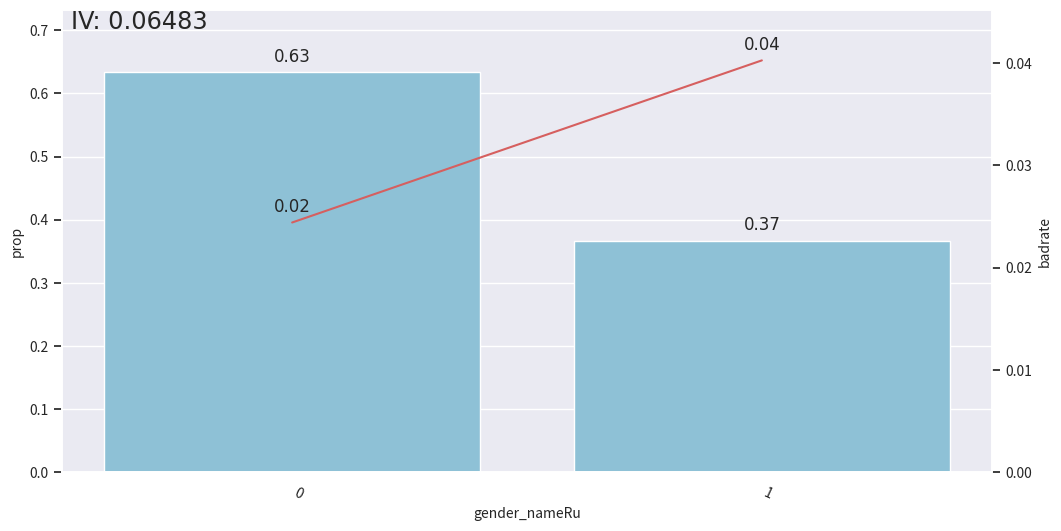

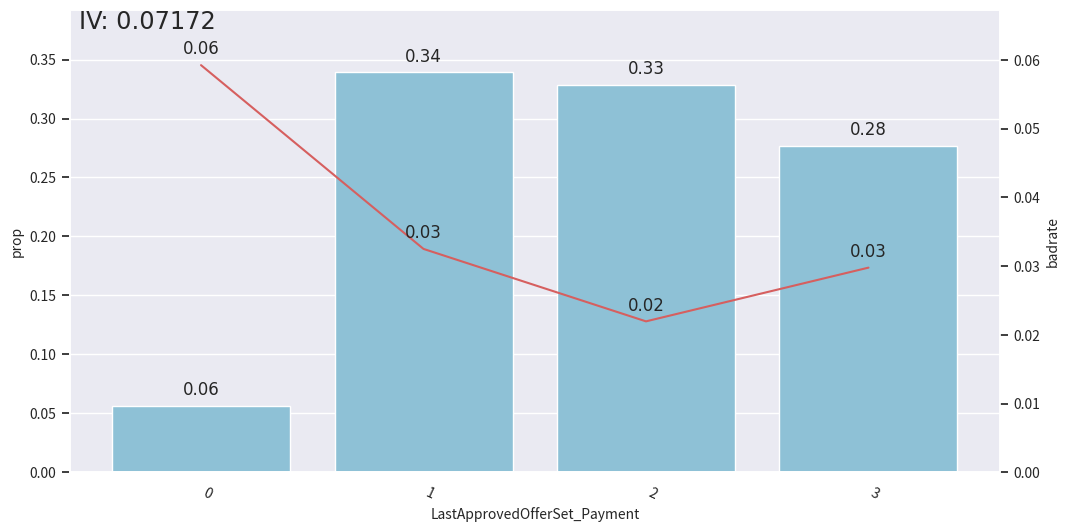

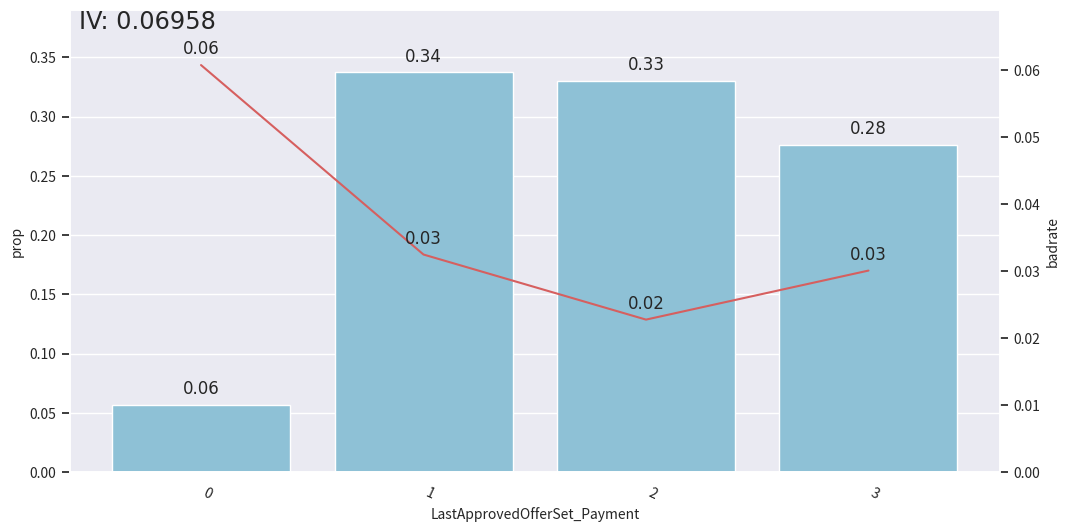

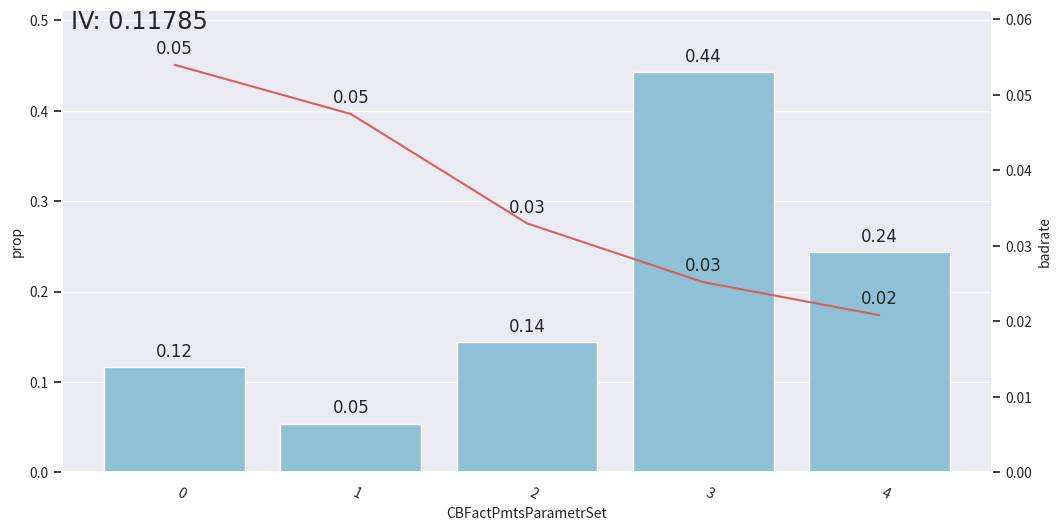

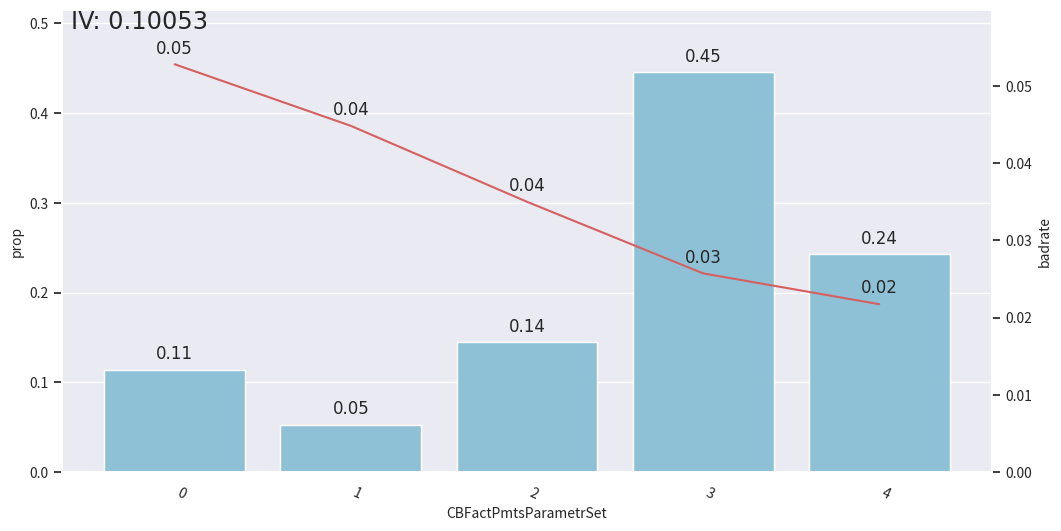

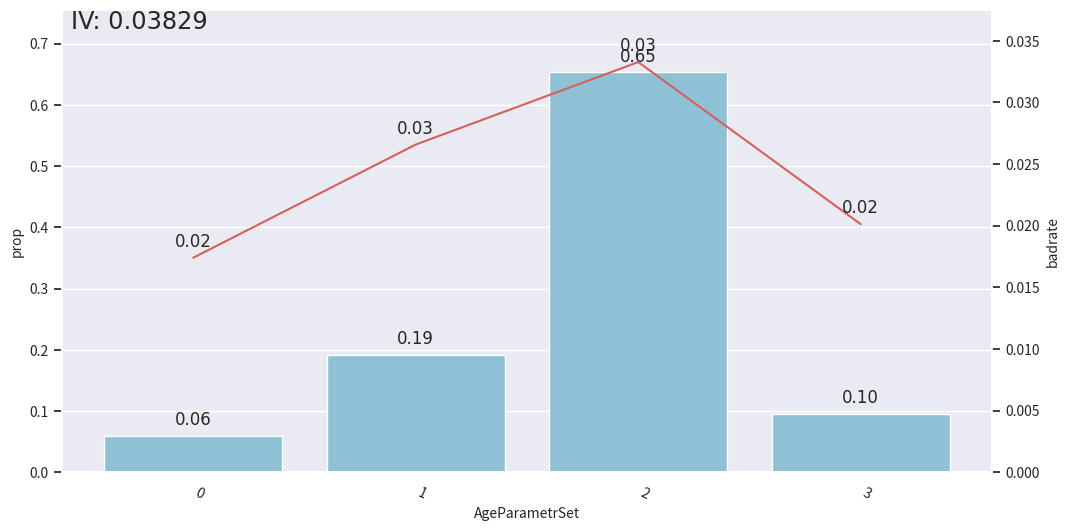

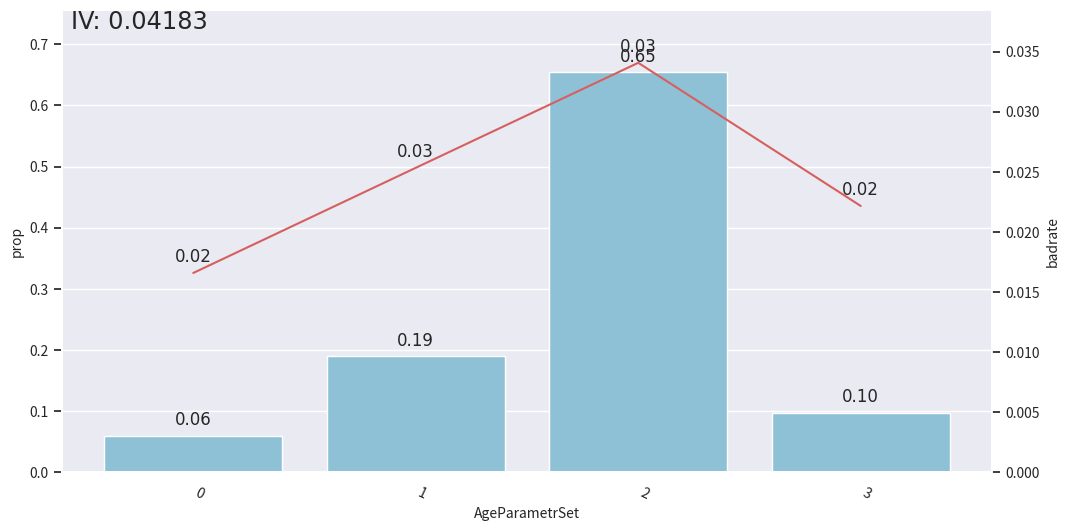

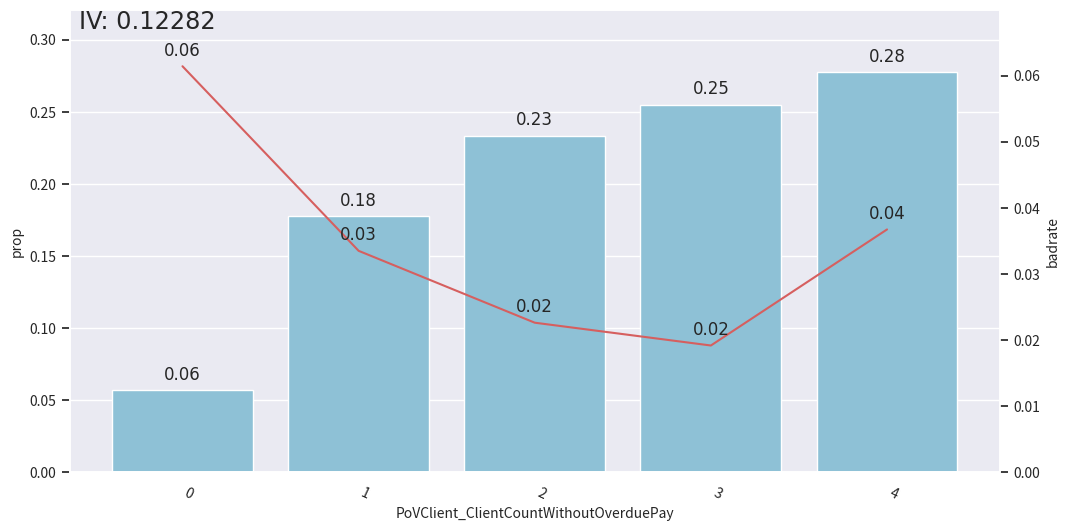

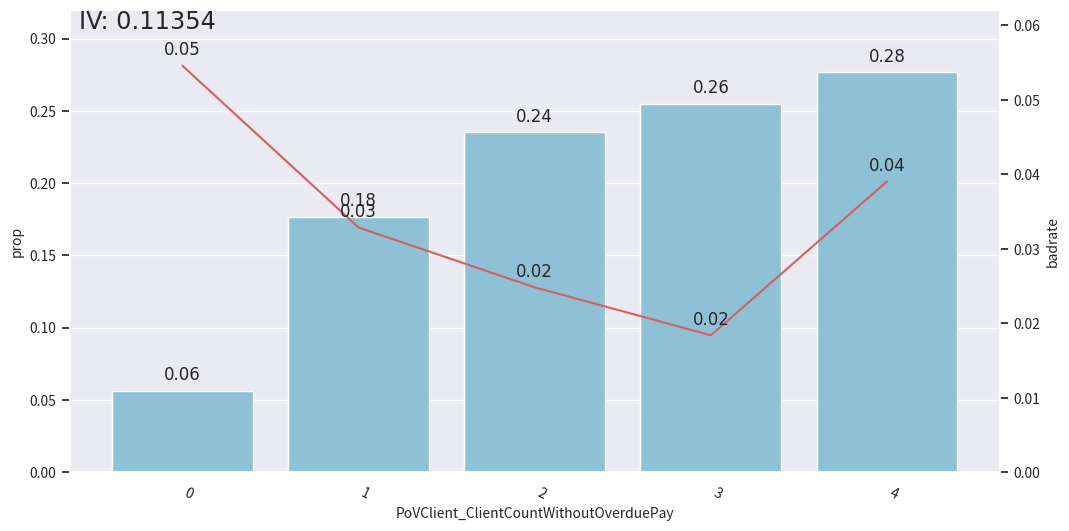

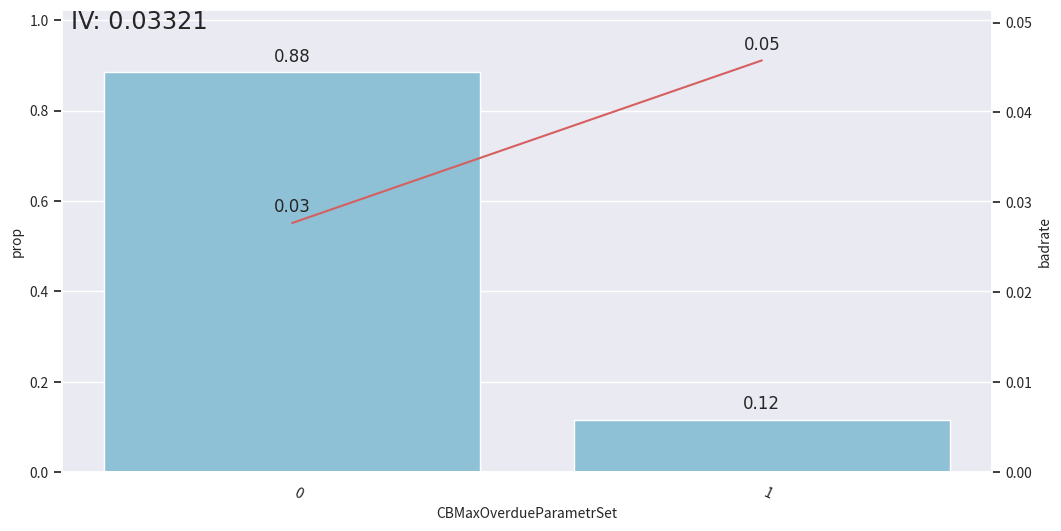

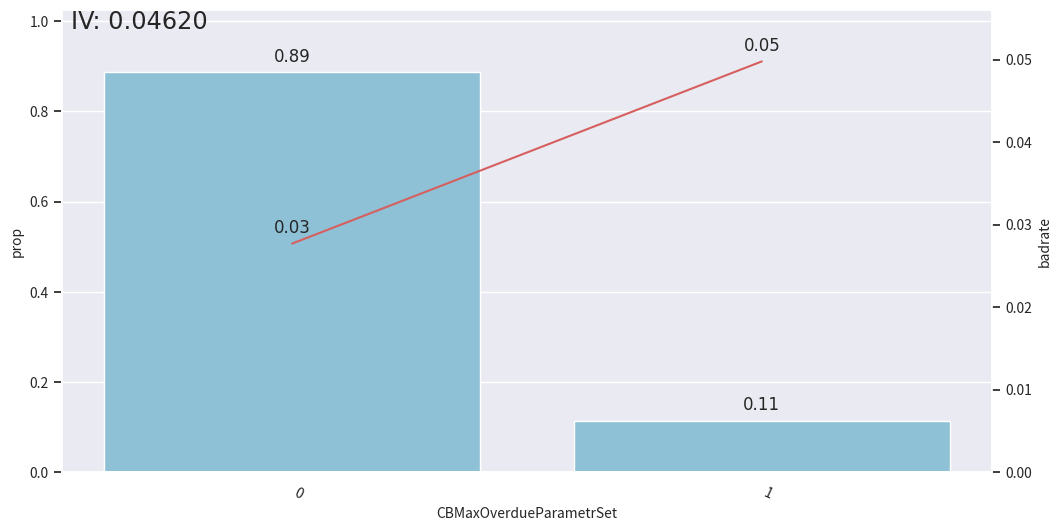

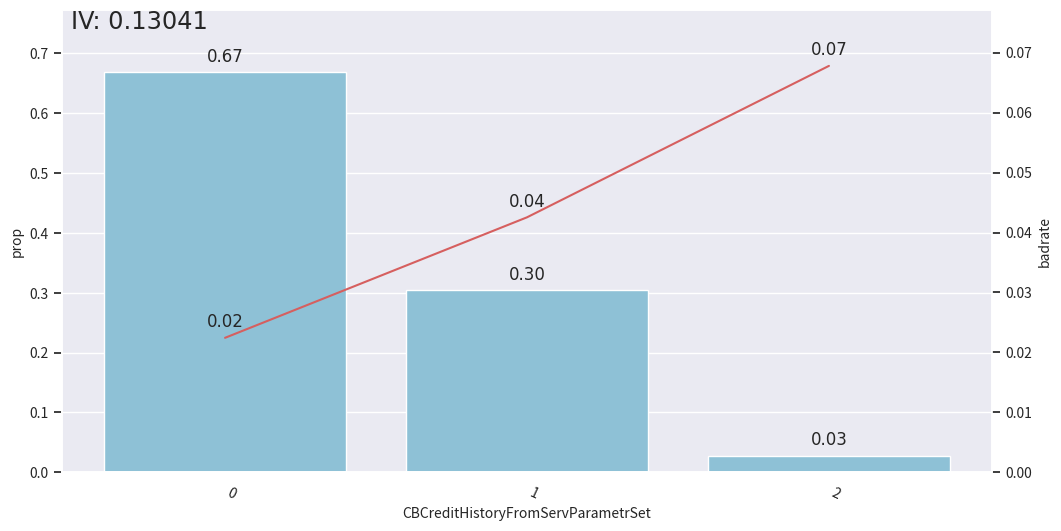

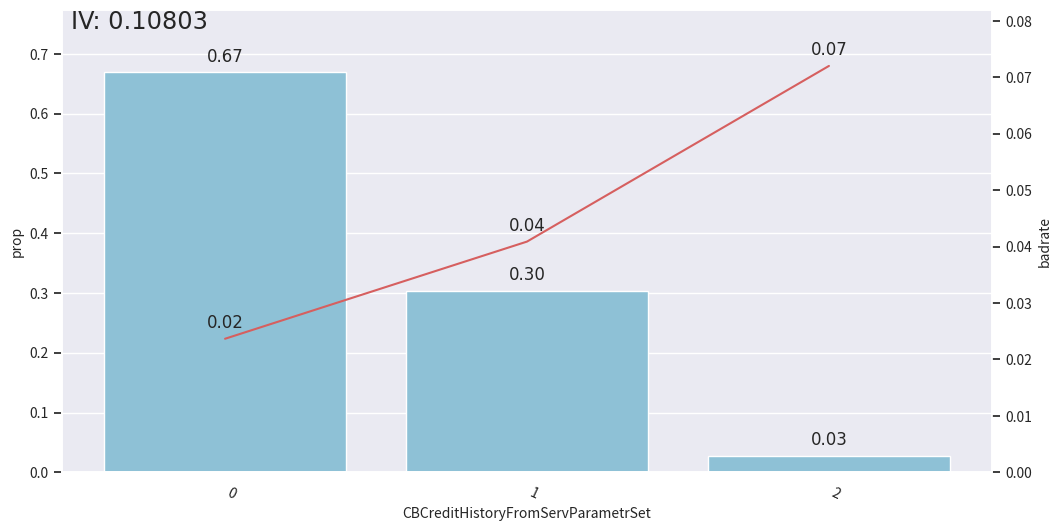

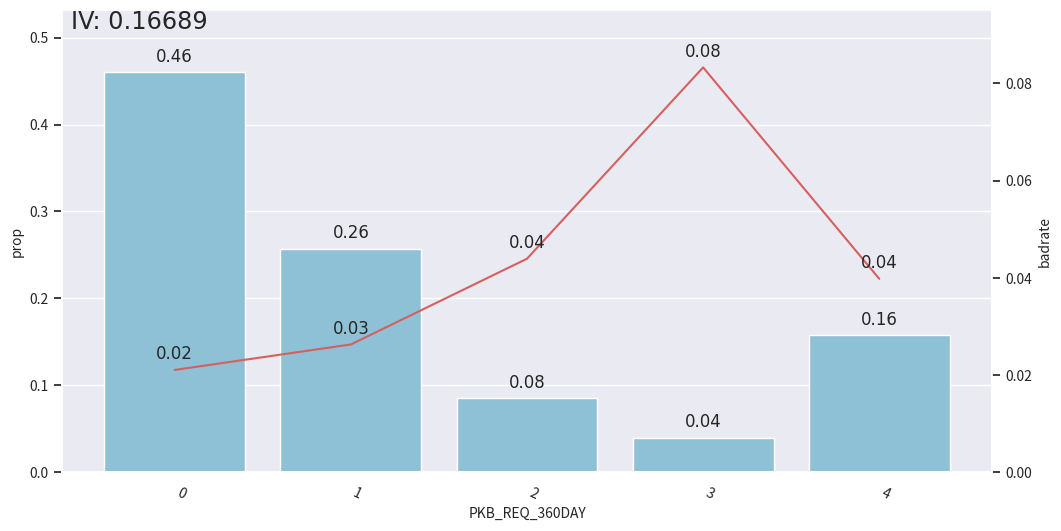

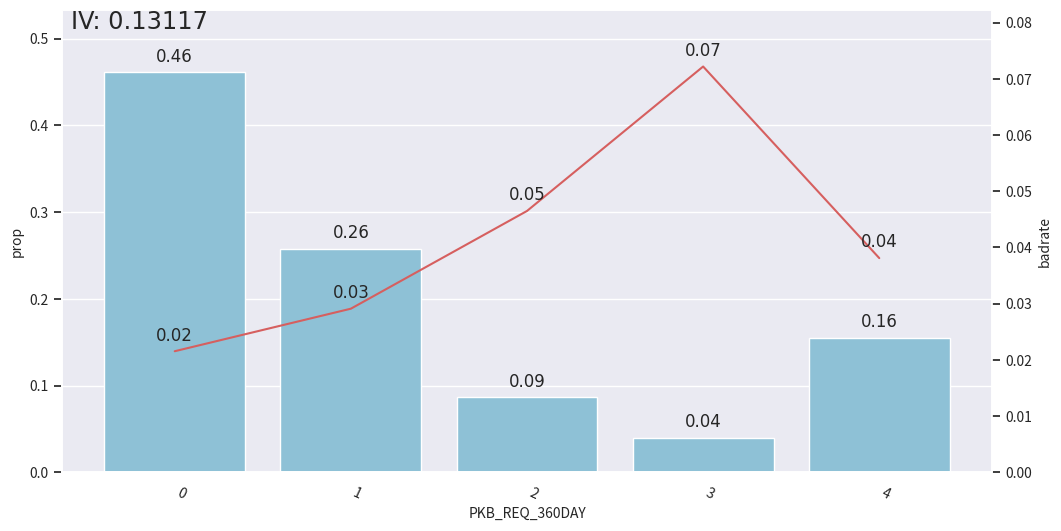

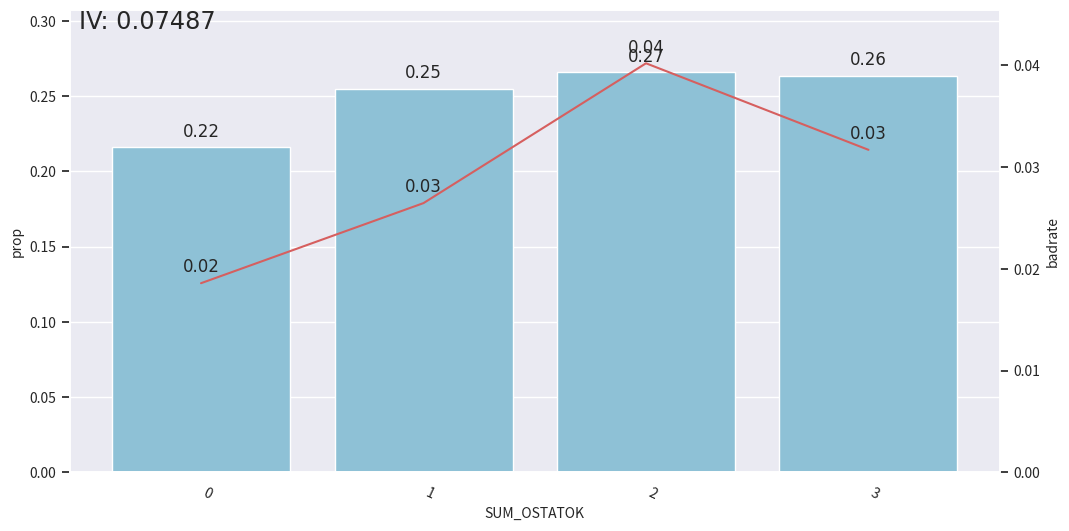

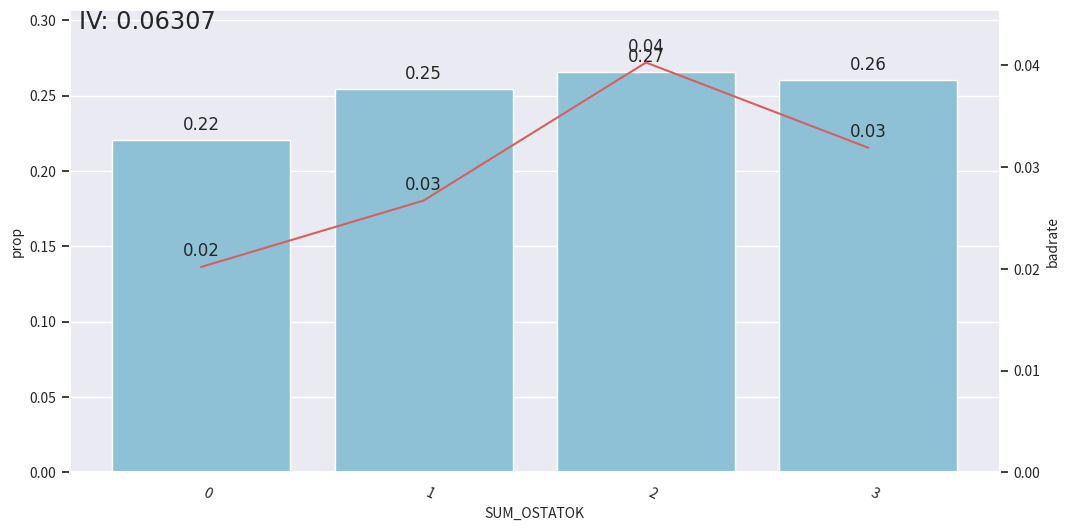

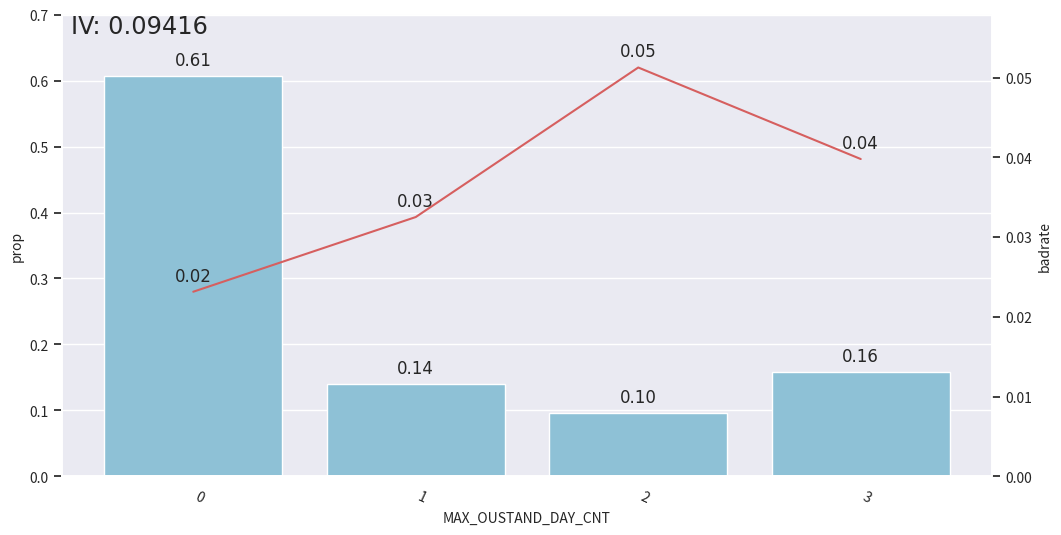

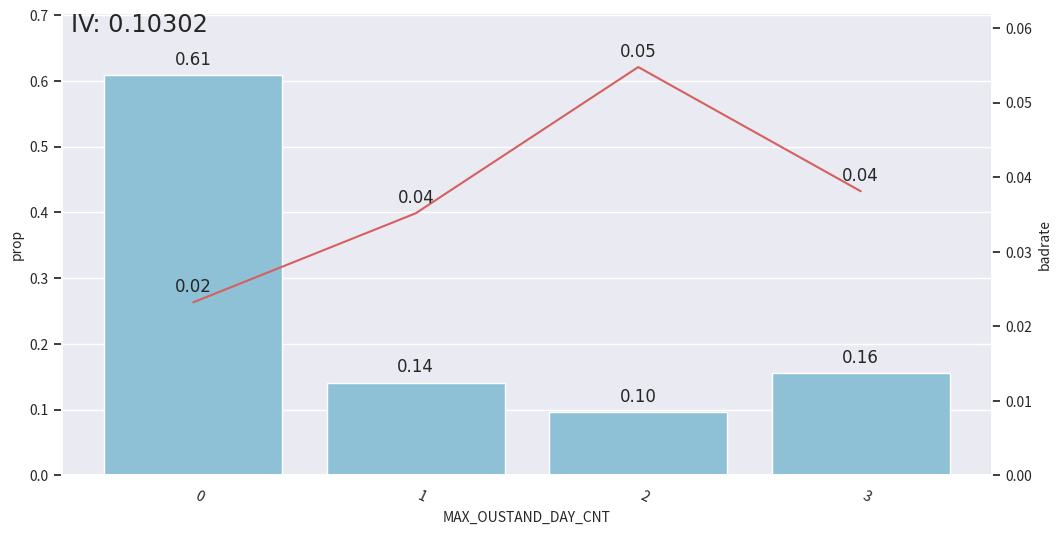

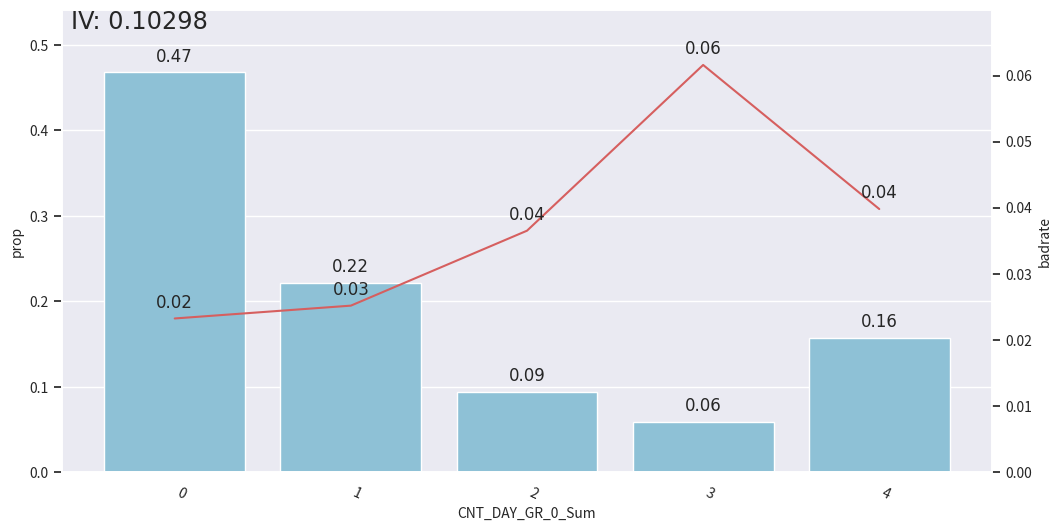

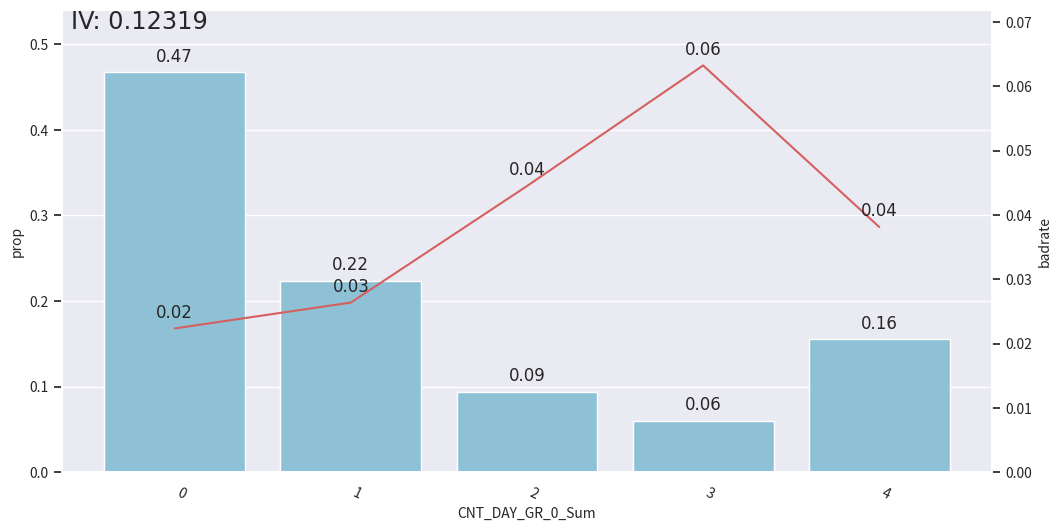

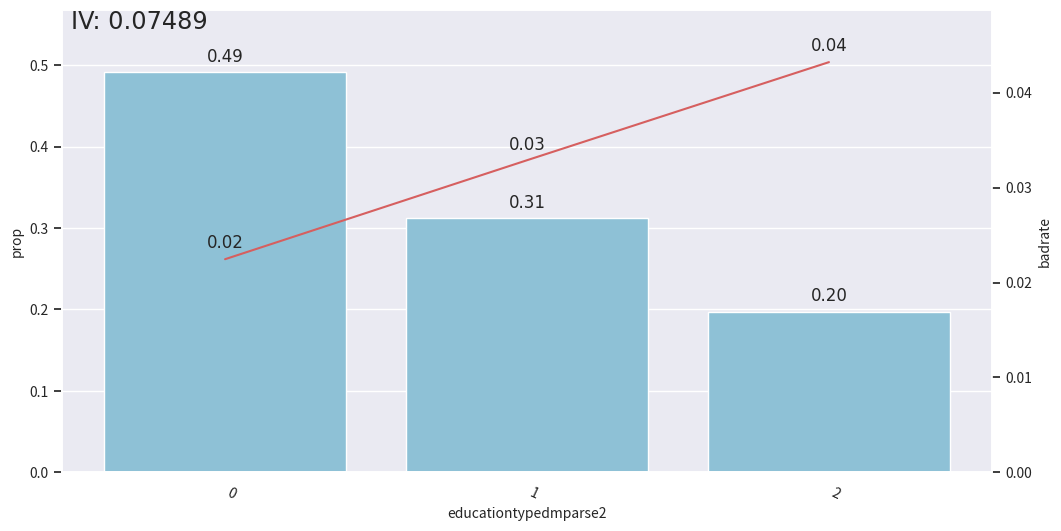

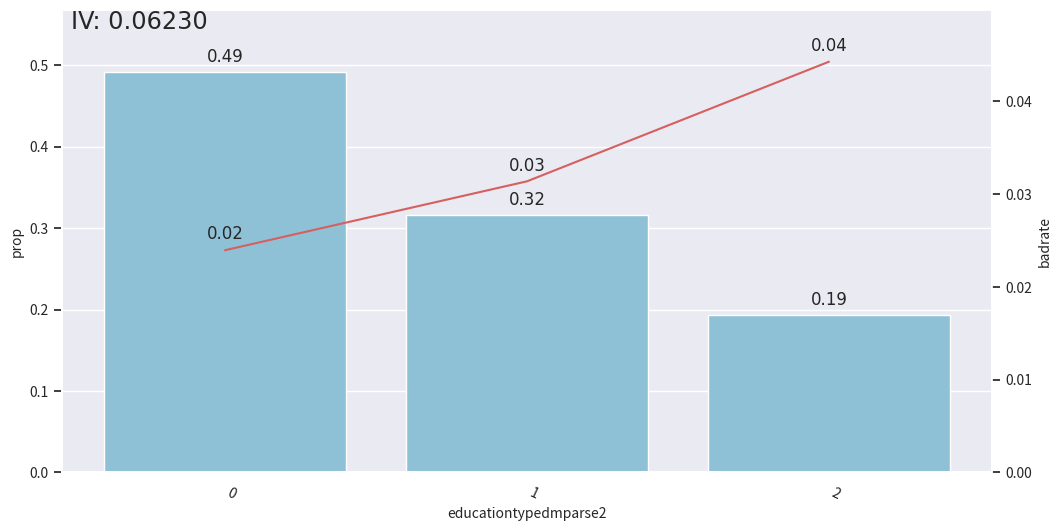

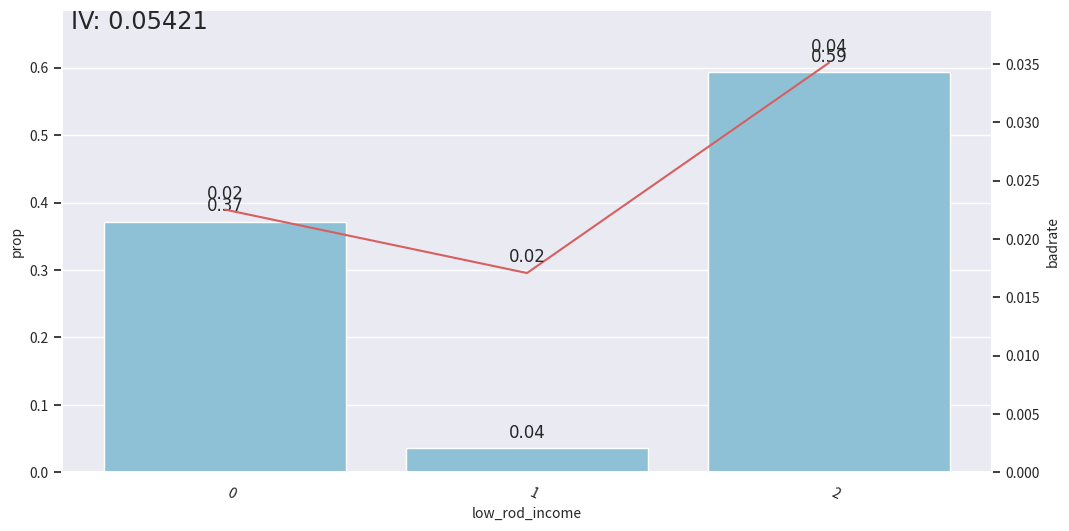

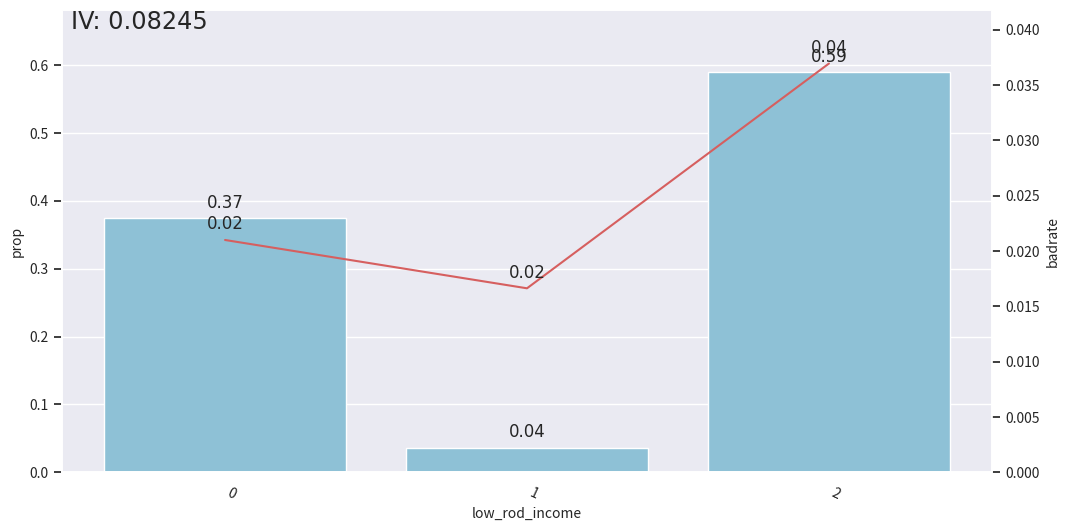

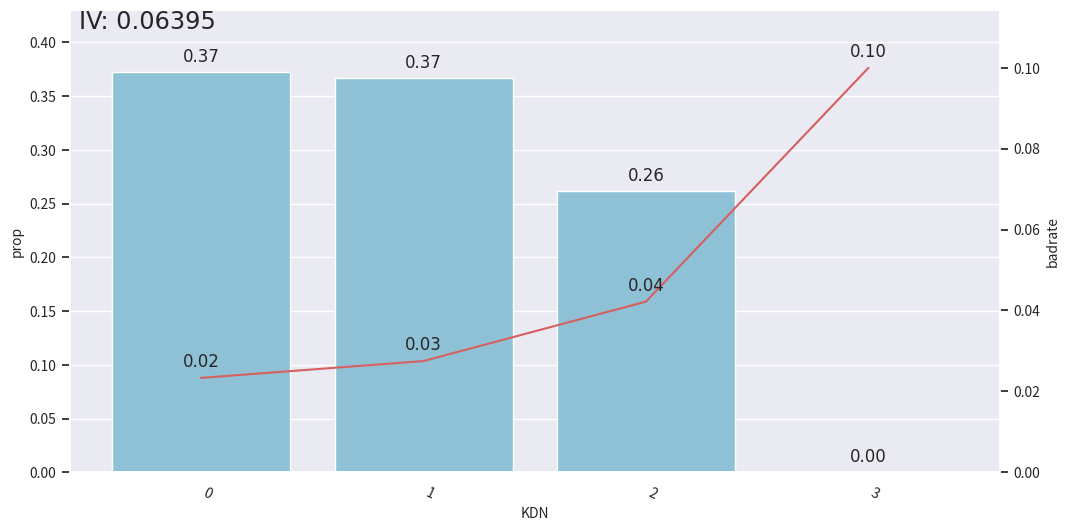

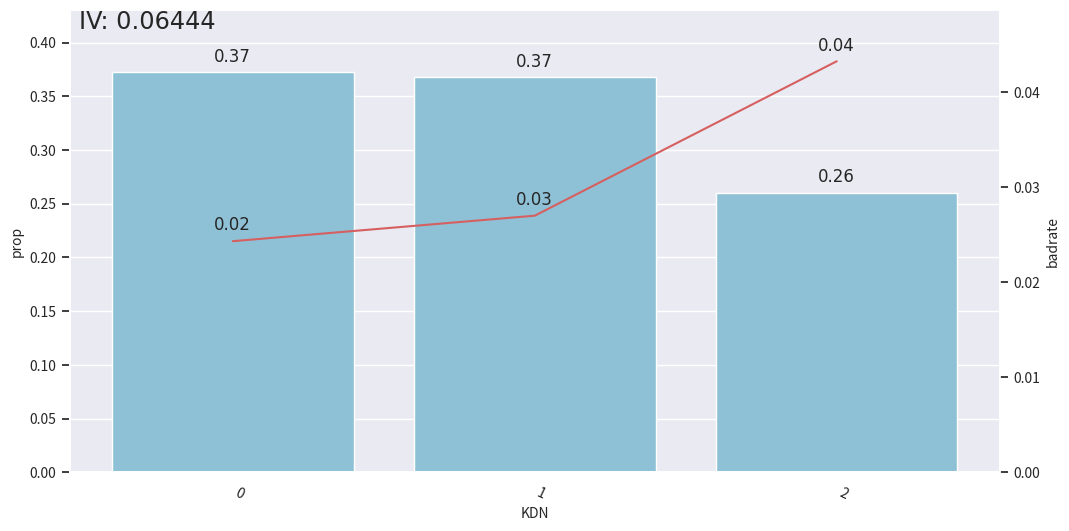

In [21]:
#Просмотр графиков с бинами:
for feature in X_train1.columns:
    bin_plot(train_selected_bin1, x=feature, target =y_train1)
    bin_plot(test_selected_bin1, x=feature, target =y_test1)

In [22]:
#трансформирование в WOE
t1=toad.transform.WOETransformer()
#трансформация тренировочного датасета
train_woe1 = t1.fit_transform(X=train_selected_bin1, y=y_train1)
#трансформация тестового датасета
test_woe1 = t1.transform(test_selected_bin1)

In [23]:
#запись переменных, использующихся в модели в новую переменную features_use
features_use1 = train_woe1.columns.values.tolist()

In [24]:
#Просмотр порядка листа переменных
features_use1

['gender_nameRu',
 'LastApprovedOfferSet_Payment',
 'CBFactPmtsParametrSet',
 'AgeParametrSet',
 'PoVClient_ClientCountWithoutOverduePay',
 'CBMaxOverdueParametrSet',
 'CBCreditHistoryFromServParametrSet',
 'PKB_REQ_360DAY',
 'SUM_OSTATOK',
 'MAX_OUSTAND_DAY_CNT',
 'CNT_DAY_GR_0_Sum',
 'educationtypedmparse2',
 'low_rod_income',
 'KDN']

In [96]:
#модель логист.регрессии
#поиск лучших параметров
model = LogisticRegression(max_iter=500)
#диапазон значений для весов
weights = np.linspace(0.0,0.99,20)
#создание dictionary для поиска параметров
param_grid = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
              'penalty' :['l1', 'l2', 'elasticnet'],
              'C': [0.01, 1, 10, 100], 
              'class_weight': [{0:x, 1:1.0-x} for x in weights]}
#  Подгонка поиска по сетке к тренировочному дасету
gridsearch = GridSearchCV(estimator= model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(5), 
                          n_jobs=-1, 
                          scoring='roc_auc',
                          verbose=0)
gridsearch.fit(train_woe1, y_train1)

/home/drck_gulnaz/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drck_gulnaz/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drck_gulnaz/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drck_gulnaz/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drck_gulnaz/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/drck_gulnaz/.venv/lib/python3.12/site-packages/sklearn

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=500), n_jobs=-1,
             param_grid={'C': [0.01, 1, 10, 100],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.05210526315789474,
                                           1: 0.9478947368421052},
                                          {0: 0.10421052631578948,
                                           1: 0.8957894736842105},
                                          {0: 0.1563157894736842,
                                           1: 0.8436842105263158},
                                          {0: 0.20842105263157895,
                                           1:...
                                           1: 0.2705263157894737},
                                          {0: 0.781578947368421,
                                           1: 0.21842105263157896},
                                          {0: 0.8336842105263158,
                                           1: 0.1663157894736842},
                                          {0: 0.8857894736842106,
                                           1: 0.11421052631578943},
                                          {0: 0.9378947368421053,
                                           1: 0.06210526315789466},
                                          {0: 0.99, 1: 0.010000000000000009}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [98]:
#просмотр лучших параметров в gridsearch
gridsearch.best_params_

{'C': 1,
 'class_weight': {0: 0.05210526315789474, 1: 0.9478947368421052},
 'penalty': 'l2',
 'solver': 'sag'}

In [25]:
#Метрики
def scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

#Визуализация confusion matrix
sns.set(font_scale=1.5)
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False, fmt='.1f', cmap="YlGnBu")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

#KS-статистика для вероятностей
def KS(y_score, y_true):
    # y_score -- вероятности для положительного класса
    return ks_2samp(y_score[y_true == 1], y_score[y_true == 0]).statistic

#AUC-метрика
def AUC(y_score, y_true):
    return roc_auc_score(y_true, y_score)

#Гибкая функция для построения ROC-кривой и подсчёта AUC прямо на графике
def plot_roc_curve_from_proba(y_true, y_score, label=None, color=None, ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    if ax is None:
        plt.figure(figsize=(6, 6))
        ax = plt.gca()
    ax.plot(fpr, tpr, linewidth=2, label=f"{label} (AUC={auc:.3f})", color=color)
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.7)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Доля ложно-положительных')
    ax.set_ylabel('Доля истинно-положительных')
    ax.legend(loc="lower right")
    ax.set_title('ROC-кривая')
    return auc

train KS: 0.33081202938670184
train AUC: 0.7252335700906735
test KS: 0.32509888839644857
test AUC: 0.7206469098106062


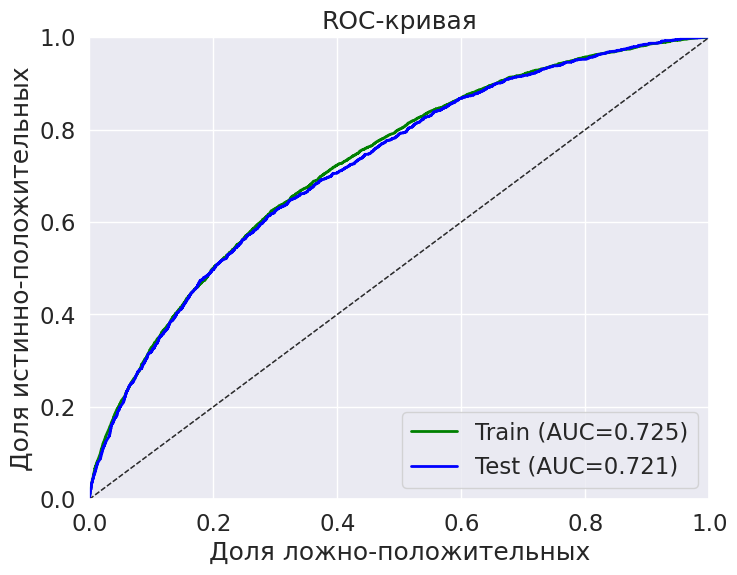

In [26]:
#Оценка на train и test с ROC-кривой, AUC и KS
def check_train_test_auc(x_train, y_train, x_test, y_test):
    lr1 = LogisticRegression(random_state=42, C=1, penalty='l2', solver='sag',
                            class_weight={0: 0.03, 1: 0.97}
                            )
    lr1.fit(x_train, y_train)
    pred_train = lr1.predict_proba(x_train)[:, 1]
    pred_test = lr1.predict_proba(x_test)[:, 1]
    print('train KS:', KS(pred_train, y_train))
    print('train AUC:', AUC(pred_train, y_train))
    print('test KS:', KS(pred_test, y_test))
    print('test AUC:', AUC(pred_test, y_test))
    #Рисуем обе ROC-кривые на одном графике
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_roc_curve_from_proba(y_train, pred_train, label='Train', color='green', ax=ax)
    plot_roc_curve_from_proba(y_test, pred_test, label='Test', color='blue', ax=ax)
    plt.show()
check_train_test_auc(x_train = train_woe1[features_use1], y_train=y_train1,
                      x_test=test_woe1[features_use1], y_test=y_test1)
#check_train_test_auc(x_train = X_res[features_use1], y_train=y_res, 
#                    x_test=test_woe1[features_use1], y_test=y_test1)

In [27]:
#просмотр intercept и коэффициентов логистической регрессии
model1 = LogisticRegression(random_state=42,C= 1, penalty= 'l2',solver= 'sag',
                                      class_weight={0: 0.03, 1: 0.97}, max_iter=300, n_jobs=-1)
model1.fit(train_woe1, y_train1)
coefficients = np.append(model1.intercept_, model1.coef_)
print('Coefficients', coefficients)

Coefficients [-0.008155    1.05933811  0.49599531  0.62267443  0.69182098  0.41750329
  0.76650582  0.33235992  0.60992028  0.33095157  0.22924166  0.18190328
  0.63893592  1.39806755  1.17347695]


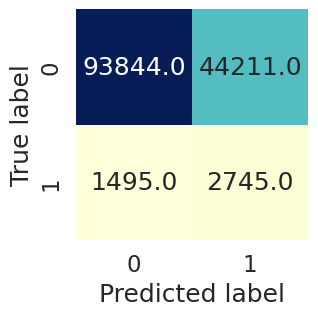

In [28]:
#accuracy, precision, recall, f1 в тренировочном датасете 
y_pred_train1 = cross_val_predict(model1, train_woe1, y_train1, cv=3)
scores(y_train1, y_pred_train1)
#визуализация матрицы ошибок в тренировочном датасете
plot_conf_mat(y_train1, y_pred_train1)

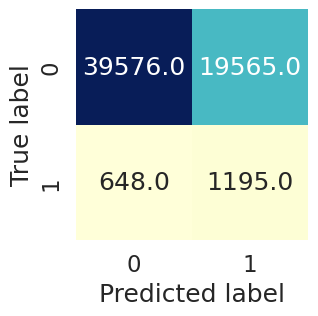

In [29]:
#accuracy, precision, recall, f1 в тестовом датасете 
y_pred_test1 = cross_val_predict(model1, test_woe1, y_test1, cv=3)
scores(y_test1, y_pred_test1)
#визуализация матрицы ошибок в тестовом датасете
plot_conf_mat(y_test1, y_pred_test1)

In [30]:
print("Classification Report:")
print(classification_report(y_train1, y_pred_train1))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    138055
           1       0.06      0.65      0.11      4240

    accuracy                           0.68    142295
   macro avg       0.52      0.66      0.46    142295
weighted avg       0.96      0.68      0.78    142295



In [31]:
print("Classification Report:")
print(classification_report(y_test1, y_pred_test1))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     59141
           1       0.06      0.65      0.11      1843

    accuracy                           0.67     60984
   macro avg       0.52      0.66      0.45     60984
weighted avg       0.96      0.67      0.78     60984



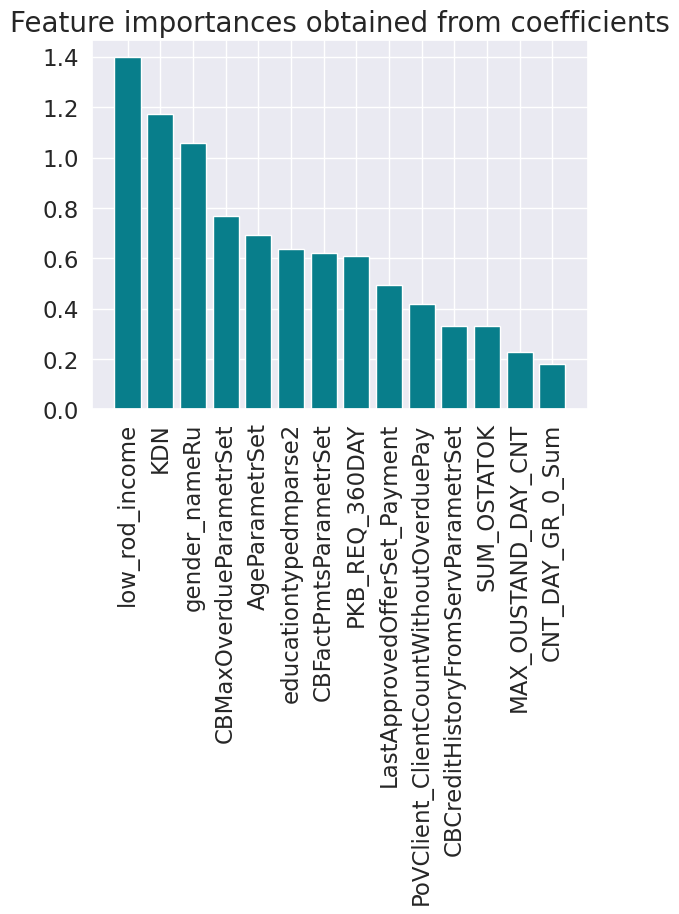

In [32]:
#расчет важности переменных, полученных из коэффициентов логистической регрессии
importances1 = pd.DataFrame(data={
    'Attribute': train_woe1.columns,
    'Importance': model1.coef_[0]
})
importances1 = importances1.sort_values(by='Importance', ascending=False)
#график важности переменных по коэффициентам логист. регрессии
plt.bar(x=importances1['Attribute'], height=importances1['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [33]:
#расчет процента пустых значений в датасете
lrdata_na = datalogmodel.isnull().sum() / len(datalogmodel) * 100
lrdata_na

NPL91_EVER                                 0.000000
gender_nameRu                              0.000000
LastApprovedOfferSet_Payment              27.631482
CBFactPmtsParametrSet                      0.000000
AgeParametrSet                             0.000000
PoVClient_ClientCountWithoutOverduePay    27.721014
CBMaxOverdueParametrSet                    0.000000
CBCreditHistoryFromServParametrSet         0.000000
PKB_REQ_360DAY                            15.695669
SUM_OSTATOK                               26.240290
MAX_OUSTAND_DAY_CNT                       15.695669
CNT_DAY_GR_0_Sum                          15.695669
educationtypedmparse2                      0.270072
low_rod_income                            59.206804
KDN                                        0.005411
dtype: float64

In [34]:
datalogmodel['NPL91_EVER'].value_counts()

NPL91_EVER
0    197196
1      6083
Name: count, dtype: int64

In [35]:
datalogvalid['NPL91_EVER'].value_counts()

NPL91_EVER
0    20843
1      541
Name: count, dtype: int64

In [36]:
y_train1.value_counts()

NPL91_EVER
0    138055
1      4240
Name: count, dtype: int64

In [37]:
y_test1.value_counts()

NPL91_EVER
0    59141
1     1843
Name: count, dtype: int64

In [54]:
#Test on validation dataset:

In [38]:
X_v1 = datalogvalid.drop('NPL91_EVER', axis = 1)
y_v1 = datalogvalid['NPL91_EVER']
val_bin1 = combiner1.transform(X_v1)
val_woe1 = t1.fit_transform(X=val_bin1, y=y_v1)

train KS: 0.34108775376654066
train AUC: 0.7148296794723478


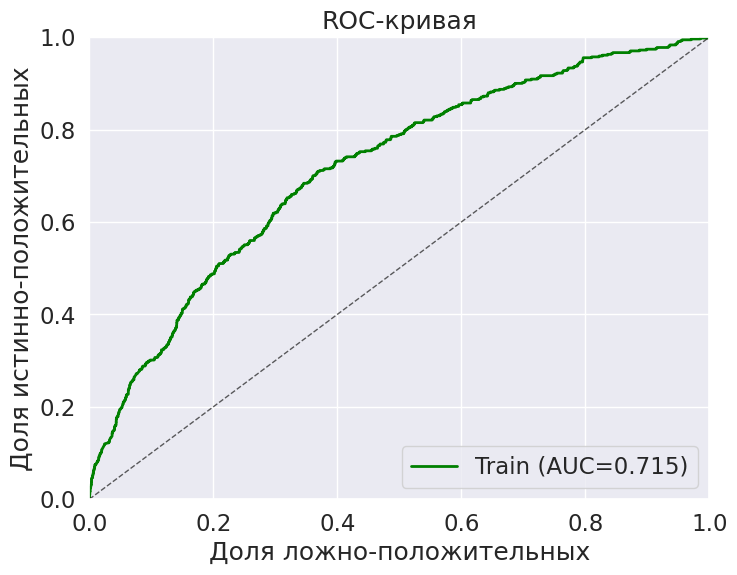

In [39]:
#Оценка на train и test с ROC-кривой, AUC и KS
def check_train_test_auc(x_train, y_train):
    lr1 = LogisticRegression(random_state=42, C=1, penalty='l2', solver='sag',
                            class_weight={0: 0.03, 1: 0.97})
    lr1.fit(x_train, y_train)
    pred_train = lr1.predict_proba(x_train)[:, 1]
    print('train KS:', KS(pred_train, y_train))
    print('train AUC:', AUC(pred_train, y_train))
    #Рисуем обе ROC-кривые на одном графике
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_roc_curve_from_proba(y_train, pred_train, label='Train', color='green', ax=ax)
    plt.show()
check_train_test_auc(x_train = val_woe1[features_use1], y_train=y_v1)

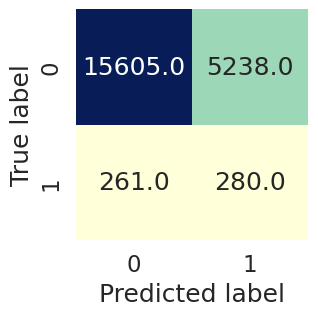

In [40]:
#accuracy, precision, recall, f1 в тренировочном датасете 
y_pred_val1 = cross_val_predict(model1, val_woe1, y_v1, cv=3)
scores(y_v1, y_pred_val1)
#визуализация матрицы ошибок в тренировочном датасете
plot_conf_mat(y_v1, y_pred_val1)

In [41]:
print("Classification Report:")
print(classification_report(y_v1, y_pred_val1))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     20843
           1       0.05      0.52      0.09       541

    accuracy                           0.74     21384
   macro avg       0.52      0.63      0.47     21384
weighted avg       0.96      0.74      0.83     21384



In [42]:
#Копирование датасета для ансамбля моделей
dataens = data.copy()

In [43]:
print(dataens.columns.tolist())

['IIN_BIN', 'OPEN_DATE', 'CONTRACT_NUMBER', 'CONTRACT_AMOUNT', 'NPL91_EVER', 'BRANCH', 'CITIZENSHIP', 'TRUST_PHONE_NUMBER', 'FAMILY_STATUS', 'FACT_ADDRESS', 'EDUCATION', 'JURIDICAL_ADDRESS', 'CNT_OPEN_DEPOSIT', 'CNT_OPEN_DEPOSIT_ONLINE', 'CNT_DEPOSIT', 'CNT_CLOSE_DEPO', 'AMOUNT_REPLENISH_DEPO', 'AMOUNT_WITHDRAWAL_DEPO', 'CNT_LOAN', 'CNT_LOAN_ONLINE', 'MONTH_LOAN_PAY_AMOUNT', 'BONUS_SIZE', 'AMOUNT_OUT_MONEY', 'AMOUNT_SOC_PAYOUT', 'AMOUNT_PENSION', 'AMOUNT_CASHIN_ATM', 'CNT_MCC_CAT', 'VOLUME_NONCASH_TRANS', 'AMOUNT_CASHOUT_ATM', 'CNT_INTER_TRANSFER_HB', 'AMOUNT_INTER_TRANSFER_HB', 'CNT_TRAN_OTHER_BANK', 'AMOUNT_TRAN_OTHER_BANK', 'CNT_TRANSFER_KASPI', 'AMOUNT_TRANSFER_KASPI', 'CNT_KASPI_CARD_TRANSFER', 'CNT_INBOX_TRANSF_KASPI', 'VOLUME_INBOX_TRANSF_KASPI', 'CNT_INBOX_TRANSF_HALYK', 'VOLUME_INBOX_TRANSF_HALYK', 'CNT_PAYMENT', 'PAYMENT_AMOUNT', 'CNT_UNIQUE_MCG_USE', 'CNT_BANK_PRODUCTS_DEBIT_CARD', 'MOBILE_OS', 'MOBILE_MODEL', 'MOBILE_BRAND', 'MAU_FIREBASE', 'MAU_AUTORIZATION', 'CNT_MOBILE_P

In [44]:
#удаление переменных из xml заявки, т.к. будут недоступны для MLOps
drop_cols = ['IIN_BIN', 'CONTRACT_NUMBER', 'CONTRACT_AMOUNT', 'FACT_ADDRESS', 'JURIDICAL_ADDRESS', 'PKB_HOME_PHONE_FL', 'TRUST_PHONE_NUMBER', 'CBClosedContrCntParametrSet', 'InternalDelinquencyAccounts_Table_shdAmount2', 'InternalDelinquencyAccounts_Table_delay', 'ChildQntyParametrSet', 'gender_nameRu', 'InternalDelinquencyAccounts_Table_balReal', 'CBOutsAmntParametrSet', 'CB2YIncomeParametrSet', 'HBShdPayMonthsParametrSet', 'InternalDelinquencyAccounts_Table_shdAmount', 'LastApprovedOfferSet_Payment', 'CBMPtsAmntHBCardParametrSet', 'BINsWithPmntsIn45DaysCntParametrSet', 'CBMaxTrmntdCntrctAmntParametrSet', 'HBMPtsAmntUnsParametrSet', 'HalykBankCPPParametrSet', 'PoVClient_Client72hCountOrderOnlineApproved', 'documents_document_type_nameRu', 'KDNParametrSet', 'PoVClient_Client24hCountOrderOnlineCreated', 'PoVContactPhone_ContactPhone90dCountMaxAplicationOnlineClient', 'CBOutsAmntUnsParametrSet', 'CPPTotalPaysCountParametrSet', 'CBoverdues_60_90ParametrSet', 'PaymentInColvirsLineParametrSet', 'PoVClient_Client90dDebitCardCreditTransactionEcomUnicMonth', 'GtsvpServiceResponseData_avgAmount', 'CPPPaysCountOldParametrSet', 'InternalDelinquencyAccounts_Table_amount', 'PoVClient_Client360dDebitCardCreditCreditTransactionAmount', 'PoVClient_Client360dDebitCardCreditTransactionEcomAmount', 'CardTotalParametrSet', 'PoVClient_Client24hCountOrderOnlineIssued', 'CBFactPmtsParametrSet', 'PoVClient_Client180dDebitCardCreditCreditTransactionUnicMonth', 'regAddress_region_nameRu', 'HBMPtsAmntParametrSet', 'AFCounterParametrSet', 'birthPlace_region_nameRu', 'UnicodesWithPmntsIn45DaysCntParametrSet', 'AgeParametrSet', 'PoVClient_Client24hCountOrderOnlineApproved', 'VerIncAmountParametrSet', 'ColvirDepositAccount_Prolong', 'ColvirDepositAccount_DepoRetAcc', 'PoVClient_ClientCountWithoutOverduePay', 'CBPeriodFromFirstContrParametrSet', 'PoVContactPhone_ContactPhone30dCountMaxAplicationOnlineClient', 'PoVClient_Client180dDebitCardCreditCreditTransactionAmount', 'CBIncomeParametrSet', 'HBMPtsAmntGdsParametrSet', 'PoVClient_Client0dMaxUpsellOnline', 'IsV_AFParametrSet', 'PoVClient_Client360dDebitCardCreditCreditTransactionUnicMonth', 'ColvirAccountAmountParametrSet', 'CardPaysCountOldParametrSet', 'PoVClient_Client30dMaxDownsaleAmountOnline', 'PoVClient_Client90dDebitCardDebitTransactionAmount', 'regAddress_district_nameRu', 'ColvirDepositAccount_ValCode', 'PoVClient_Client90dDebitCardCreditCreditTransactionUnicMonth', 'InternalDelinquencyAccounts_Table_dclCode', 'HBOutsAmntUnsParametrSet', 'PoVClient_Client24hCountProductMobileOnlineIssued', 'PoVContactPhone_ContactPhone72hCountMaxContactsOnlineClient', 'CBoverdues_30_60ParametrSet', 'NBCardParametrSet', 'InternalDelinquencyAccounts_Table_bal', 'CBCurDelayMaxAmountParametrSet', 'PoVClient_Client24hMaxUpsellOnline', 'PoVClient_Client180dDebitCardCreditTransactionCommunalAmount', 'CB1YIncomeParametrSet', 'PoVClient_Client90dDebitCardCreditTransactionCommunalAmount', 'PoVClient_Client360dDebitCardDebitTransactionUnicMonth', 'ColvirDepositAccount_Amount', 'NBCPPParametrSet', 'xComPaymentsParametrSet', 'InternalDelinquencyAccounts_Table_crInter', 'PoVClient_Client360dDebitCardCreditTransactionCommunalAmount', 'client_id', 'ColvirDepositAccount_DclName', 'CPPPaysCountParametrSet', 'PoVMobile_Mobile24hCountClientDistinct', 'HBCreditHistoryFromServParametrSet', 'CBMaxOverdueAmountParametrSet', 'dtable_Salary2ParametrSet', 'PoVClient_Client360dDebitCardCreditTransactionCommunalUnicMonth', 'CPPTotalParametrSet', 'PoVClient_Client360dDebitCardCreditTransactionEcomUnicMonth', 'fcb_reference_id', 'HBOutsAmntGdsParametrSet', 'CBMPtsAmntParametrSet', 'HBOutsAmntParametrSet', 'RandomParametrSet', 'HBIsRestrParametrSet', 'PoVClient_Client0dCountOrderOnlineIssued', 'PoVClient_Client180dDebitCardCreditTransactionEcomUnicMonth', 'documents_document_status_nameRu','ColvirDepositAccount_DepName', 'citizenship_nameRu', 'BaseX_BinsCountParametrSet', 'CBShdPayMonthsParametrSet', 'PoVClient_Client360dDebitCardDebitTransactionAmount', 
'dtable_Salary3ParametrSet', 'CBIssuedHBContrCntParametrSet', 'birthPlace_district_nameRu', 'HalykBankCardParametrSet', 'HBCreditHistoryParametrSet', 'CardTotalPaysCountParametrSet', 'LastApprovedOfferSet_Amount', 'HalykBankCPPOldParametrSet', 'ASPFlagParametrSet', 'PoVClient_Client180dDebitCardDebitTransactionUnicMonth', 'CBCurMaxOverdueParametrSet', 'FinalIncomeOldParametrSet', 'documents_document_issueOrganization_nameRu', 'CBMaxOverdueParametrSet', 'PoVContactPhone_ContactPhone30dCountMaxContactsOnlineClient', 'PoVContactPhone_ContactPhone0dCountMaxAplicationOnlineClient', 'PoVClient_Client180dDebitCardDebitTransactionAmount', 'InternalDelinquencyAccounts_Table_debCount', 'HBOutsAmntMrtgParametrSet', 'PoVContactPhone_ContactPhone7dCountMaxContactsOnlineClient', 'CB3YIncomeParametrSet', 'PoVClient_Client180dDebitCardCreditTransactionCommunalUnicMonth', 'CBFactPmts1YParametrSet', 'Unicode#1WithPmntsIn45DaysPaysCntParametrSet', 'BINsCntParametrSet', 'ColvirDepositAccount_StatName', 'nationality_nameRu', 'IsCPPPaysInLastMonthParametrSet', 'FinalIncomeParametrSet', 'ColvirDepositAccount_SumDepoDog', 'ColvirDepositAccount_AccCode', 'ColvirDepositAccount_CodeAcc', 'IsCPPPaysInLast2MonthsParametrSet', 'FinalCreditHistoryParametrSet', 'PoVClient_Client24hAmountOrderOnlineIssued', 'CBOutsAmntHBCardParametrSet', 'CardPaysCountParametrSet', 'HBMPtsAmntMrtgParametrSet', 'IncomeNPAParametrSet', 'birthPlace_country_nameRu', 'PoVClient_Client24hCountUnicProductOnlineIssued', 'MonthlyPaymentParametrSet', 'PoVClient_Client90dDebitCardCreditCreditTransactionAmount', 'HalykBankCardOldParametrSet', 'Unicode#2WithPmntsIn45DaysPaysCntParametrSet', 'CBPeriodFromLastContrParametrSet', 'PoVClient_Client90dDebitCardDebitTransactionUnicMonth', 'PoVClient_Client90dDebitCardCreditTransactionCommunalUnicMonth', 'PoVClient_Client90dDepositBalance', 'PoVClient_Client72hMaxUpsellOnline', 'CBCreditHistoryFromServParametrSet', 'PoVClient_Client72hCountOrderOnlineCreated', 'CBCreditHistoryParametrSet', 'AgeInMonthParametrSet', 'UnicodesCntParametrSet', 'LivingWageParametrSet', 'PoVContactPhone_ContactPhone24hCountMaxContactsOnlineClient', 'CBClosedKZTContrSumParametrSet', 'PoVClient_Client0dMaxRequestAmountOnline', 'BINsCntdssb_ocds_paramset', 'IsCardPaysInLast2Monthsdssb_ocds_paramset', 'LivingWagedssb_ocds_paramset', 'CBHasCreditHistdssb_ocds_paramset', 'CBIssuedHBContrCntdssb_ocds_paramset', 'HBShdPayMonthsdssb_ocds_paramset', 'CB1YIncomedssb_ocds_paramset', 'CBIncomedssb_ocds_paramset', 'SalaryByWorddssb_ocds_paramset', 'FinalIncomeOlddssb_ocds_paramset', 'IsApplFormActualdssb_ocds_paramset', 'HBMPtsAmntCarddssb_ocds_paramset', 'CPPTotaldssb_ocds_paramset', 'Unicode#1WithPmntsIn45DaysPaysCntdssb_ocds_paramset', 'CBClosedContrCntdssb_ocds_paramset', 'CBCurMaxOverduedssb_ocds_paramset', 'CBOutsAmntHBCarddssb_ocds_paramset', 'CBMaxOverdueAmountdssb_ocds_paramset', 'Unicode#2WithPmntsIn45DaysPaysCntdssb_ocds_paramset', 'ReqAmntDivIncomedssb_ocds_paramset', 'HBClosedContrCntdssb_ocds_paramset', 'ColvirAccountAmountdssb_ocds_paramset', 'CBOutsAmntUnsdssb_ocds_paramset', 'CBOutsAmntdssb_ocds_paramset', 'CBoverdues_30_60dssb_ocds_paramset', 'CBShdPayMonthsdssb_ocds_paramset', 'HBMPtsAmntGdsdssb_ocds_paramset', 'HalykBankCPPOlddssb_ocds_paramset', 'TransactionInAvgSum90dssb_ocds_paramset', 'UnicodesWithPmntsIn45DaysCntdssb_ocds_paramset', 'xComPaymentsdssb_ocds_paramset', 'CBMPtsAmntdssb_ocds_paramset', 'HBOutsAmntMrtgdssb_ocds_paramset', 'dtable_Salary2dssb_ocds_paramset', 'ChildQntydssb_ocds_paramset', 'Insurancedssb_ocds_paramset', 'TransIncomedssb_ocds_paramset', 'HasDepositSCdssb_ocds_paramset', 'CBClosedHBContrCntdssb_ocds_paramset', 'CBOpenContrCnt_360dssb_ocds_paramset', 'IncomeNPAdssb_ocds_paramset', 'CBClosedKZTContrSumdssb_ocds_paramset', 'CBoverdues_60_90dssb_ocds_paramset', 'HBHasCreditHistdssb_ocds_paramset', 'HBIsRestrdssb_ocds_paramset', 'HBMPtsAmntMrtgdssb_ocds_paramset', 'HBOutsAmntUnsdssb_ocds_paramset', 'HalykBankCarddssb_ocds_paramset', 'CardPaysCountdssb_ocds_paramset', 'CardPaysCountOlddssb_ocds_paramset', 'CB3YIncomedssb_ocds_paramset', 'FinIncBgrDbldssb_ocds_paramset', 'HBOutsAmntCarddssb_ocds_paramset', 'xComPaymentsIncomedssb_ocds_paramset', 'TransactionOutAvgSum180dssb_ocds_paramset', 'CBOverdueAmntLarger1Daydssb_ocds_paramset', 'HBOpenContrCnt_360dssb_ocds_paramset', 'CBCurDelayMaxAmountdssb_ocds_paramset', 'CBPeriodFromLastContrdssb_ocds_paramset', 'HBMPtsAmntUnsdssb_ocds_paramset', 'HBOutsAmntdssb_ocds_paramset', 'HBOutsAmntGdsdssb_ocds_paramset', 'CBMaxTrmntdCntrctAmntdssb_ocds_paramset', 'HalykBankCardOlddssb_ocds_paramset', 'NBCarddssb_ocds_paramset', 'HalykBankCPPdssb_ocds_paramset', 'CPPPaysCountOlddssb_ocds_paramset', 'FinalIncomedssb_ocds_paramset', 'VerIncAmountdssb_ocds_paramset', 'MaxAmountdssb_ocds_paramset', 'xDepIncomedssb_ocds_paramset', 'TransactionInCnt180dssb_ocds_paramset', 'CBNumberOfQueries90dssb_ocds_paramset', 'BINsWithPmntsIn45DaysCntdssb_ocds_paramset', 'CardTotaldssb_ocds_paramset', 'CardTotalPaysCountdssb_ocds_paramset', 'CBFactPmtsdssb_ocds_paramset', 'CBMaxOverduedssb_ocds_paramset', 'CBMPtsAmntHBCarddssb_ocds_paramset', 'nbcppdssb_ocds_paramset', 'CPPPaysCountdssb_ocds_paramset', 'CB2YIncomedssb_ocds_paramset', 'dtable_Salary3dssb_ocds_paramset', 'ColvirDepositAmountdssb_ocds_paramset', 'TransactionInOutDiff30dssb_ocds_paramset', 'CBOpenContrCnt_180dssb_ocds_paramset', 'CPPTotalPaysCountdssb_ocds_paramset', 'CBFactPmts1Ydssb_ocds_paramset', 'CBPeriodFromFirstContrdssb_ocds_paramset', 'HBMPtsAmntdssb_ocds_paramset', 'kdndssb_ocds_paramset', 'xCarIncomedssb_ocds_paramset', 'HBOpenContrCnt_180dssb_ocds_paramset', 'PKB_REQ_7DAY', 'PKB_REQ_30DAY', 'PKB_REQ_90DAY', 'PKB_REQ_180DAY', 'PKB_REQ_360DAY', 'ALL_DEISTV', 'ALL_ZAKRYTYE', 'USTUPKA_DEISTV', 'USTUPKA_ZAKRYTYE', 'SUM_DEISTV', 'SUM_ZAKRYTYE', 'SUM_OSTATOK', 'SUM_PAY_PERIOD', 'COUNT_DOSROCHNIH', 'SUM_DOSROCHNIH', 'COUNT_OTKRYTYE_7', 'COUNT_OTKRYTYE_30', 'COUNT_OTKRYTYE_90', 'COUNT_OTKRYTYE_180', 'COUNT_OTKRYTYE_360', 'COUNT_OTKRYTYE_720', 'COUNT_OTKRYTYE_1080', 'COUNT_ZAKRYTYE_7', 'COUNT_ZAKRYTYE_30', 'COUNT_ZAKRYTYE_90', 'COUNT_ZAKRYTYE_180', 'COUNT_ZAKRYTYE_360', 'COUNT_ZAKRYTYE_720', 'COUNT_ZAKRYTYE_1080', 'SUM_OTKRYTYE_90', 'SUM_OTKRYTYE_180', 'SUM_OTKRYTYE_360', 'SUM_OTKRYTYE_720', 'SUM_OTKRYTYE_1080', 'SUM_ZAKRYTYE_90', 'SUM_ZAKRYTYE_180', 'SUM_ZAKRYTYE_360', 'SUM_ZAKRYTYE_720', 'SUM_ZAKRYTYE_1080', 'MAX_OUSTAND_DAY_CNT', 'MAX_OUSTAND_SUM', 'MAX_OUSTAND_SUM_CUR', 'MAX_OUSTAND_DAY', 'DEISTV_HALYK', 'ZAKRYTYE_HALYK', 'DEISTV_SUM_HALYK', 'ZAKRYTYE_SUM_HALYK', 'SUM_OSTATOK_HALYK', 'SUM_PAY_PERIOD_HALYK', 'DAYS_BETWEEN_FIRST', 'DAYS_BETWEEN_LAST', 'CNT_DAY_GR_90_Sum', 'CNT_DAY_GR_60_Sum', 'CNT_DAY_GR_30_Sum', 'CNT_DAY_GR_0_Sum', 'SUM_DAY_GR_0_Sum', 'DAY_MAX_OUSTAND_SUM_CUR_1', 'MAX_OUSTAND_SUM_CUR_1', 'DAY_MAX_SUM_OUTSTND', 'MAX_SUM_OUTSTND', 'DAY_MAX_SUM_OUTSTND_CONTRIB', 'MAX_SUM_OUTSTND_CONTRIB', 'DAY_MAX_SUM_PAY_PERIOD', 'MAX_SUM_PAY_PERIOD', 'DAY_MAX_TOTAL_SUM_CREDIT_LIMIT', 'MAX_TOTAL_SUM_CREDIT_LIMIT', 'regaddressnamerudmparse2', 'childqntydmparse2', 'maritalstatusdmparse2', 'educationtypedmparse2', 'positiontypedmparse2', 'housingtypedmparse2', 'verincamountdmparse2', 'low_rod_income', 'datediff_contropendate_documentbegindate', 'datediff_contropendate_GtsvpServiceResponseData_Request_documentIssueDate', 'datediff_contropendate_regAddress_region_changeDate', 'datediff_contropendate_birthPlace_region_changeDate', 'datediff_contropendate_ColvirDepositAccount_Fromdate', 'datediff_contropendate_documents_document_iIvalidityDate', 'datediff_contropendate_documents_document_endDate', 'KDN']
dataens.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [45]:
#Выбор переменных по iv, % пустых значений и корреляции
dataens, dropped = toad.selection.select(dataens, target = 'NPL91_EVER', empty = 0.9, iv = 0.05, corr = 0.7, return_drop=True)
print(dataens.shape)

(224663, 122)


In [46]:
#Просмотр размера датасета
dataens.shape

(224663, 122)

In [47]:
#Разделение датасета на валидационную и моделируемую выборки
dataensmodel = dataens[dataens['OPEN_DATE'] <= '2023-12-31']
del dataensmodel['OPEN_DATE']
dataensvalid = dataens[dataens['OPEN_DATE'] >= '2024-01-01']
del dataensvalid['OPEN_DATE']
print(dataensmodel.shape, dataensvalid.shape)

(203279, 121) (21384, 121)


In [48]:
#заменяю inf и -inf средним значением:
def replace_inf_with_mean(df):
    float64_columns = df.select_dtypes(include = ['float64']).columns
    for col in float64_columns:
        df[col].replace([np.inf, -np.inf], 0, inplace = True)
replace_inf_with_mean(data)
#заменяю пустые значения
def replace_na(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            if df[col].isnull().any():
                df[col].fillna(0, inplace = True)
        elif df[col].dtype == 'object':
            if df[col].isnull().any():
                df[col].fillna('None', inplace = True)
replace_na(data)
#Выделяю зависимую переменную
X = dataensmodel.drop('NPL91_EVER', axis = 1)
y = dataensmodel['NPL91_EVER']
#Разделяю датасет без зависимой переменной на числовые и нечисловые переменные: 
numeric_df = X.select_dtypes(include=[np.number])
object_df = X.select_dtypes(include=[object])

numeric_df = numeric_df.reset_index(drop=True)

object_df = object_df.reset_index(drop=True)
object_df = object_df.astype(str)
#Кодирую категориальные столбцы
label_encoders = {}
for column in object_df.columns:
    le = LabelEncoder()
    object_df[column] = le.fit_transform(object_df[column])
    label_encoders[column] = le
#Масштабирую числовые столбцы
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
#Объедяю масштабированные числовые столбцы и закодированные категориальные столбцы
final_X = pd.concat([scaled_numeric_df, object_df], axis=1)

In [49]:
#Разделяю датасет на трейн и тестовые выборки
y = dataensmodel['NPL91_EVER']
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size = 0.3, random_state = 42)
X_train.shape

(142295, 120)

In [50]:
#Бинирование данных c разделением пустых значений:
combinerens = toad.transform.Combiner()
combinerens.fit(X_train, y_train, method = 'chi', min_samples = 0.05, empty_separate = True)
train_selected_binens = combinerens.transform(X_train)
test_selected_binens = combinerens.transform(X_test)

In [51]:
#Инициализация моделей со стандартными параметрами
#LightGBM
lgbm = LGBMClassifier(
    boosting_type='gbdt',   #Градиентный бустинг на решающих деревьях
    num_leaves=30,          #Максимальное количество листьев на одном дереве
    max_depth=6,           #Максимальная глубина дерева (-1 отсутствие ограничения)
    subsample=0.8,          #Доля выборки для построения каждого дерева (bagging, уменьшает переобучение)
    learning_rate=0.05,     #Скорость обучения, влияет на шаг обновления весов бустинга
    n_estimators=200,       #Количество деревьев (итераций бустинга)
    colsample_bytree=0.8,   #Доля признаков, используемых при построении каждого дерева (feature fraction)
    random_state=42         #Фиксирует генератор случайных чисел для воспроизводимости результатов
)
#XGBoost
xgb = XGBClassifier(
    objective='binary:logistic', #Задача бинарной классификации с логистической функцией потерь
    booster='gbtree',            #Использовать деревья решений как базовые алгоритмы
    nthread=4,                   #Количество потоков для параллельных вычислений
    learning_rate=0.05,          #Скорость обучения
    n_estimators=200,            #Количество деревьев/итераций бустинга
    gamma=0.7,                   #Минимальное снижение функции потерь для разбиения узла (регуляризация)
    reg_lambda=0.8,              #L2-регуляризация на веса (регуляризация переобучения)
    min_child_weight=50,         #Минимальная сумма весов для дочернего узла (контроль переобучения)
    max_depth=5,                 #Максимальная глубина дерева
    subsample=0.6,               #Доля обучающей выборки для каждого дерева (bagging)
    colsample_bytree=0.4,        #Доля признаков для каждого дерева (feature bagging)
    alpha=0.8,                   #L1-регуляризация на веса (регуляризация переобучения)
    random_state=42,             #Фиксирует генератор случайных чисел
    scale_pos_weight=80,         #Балансировка классов
    eval_metric='auc'            #Метрика для оценки качества во время обучения — площадь под ROC-кривой
)
#CatBoost
catboost = CatBoostClassifier(
    iterations=200,              #Количество деревьев (итераций бустинга)
    learning_rate=0.05,          #Скорость обучения
    depth=6,                     #Глубина дерева
    bagging_temperature=2,       #Контроль случайности для bagging
    random_strength=1,           #Величина шума для случайности при выборе признаков (борьба с переобучением)
    subsample=0.8,               #Доля строк для построения каждого дерева (bagging)
    random_seed=42,              #Фиксирует генератор случайных чисел
    verbose=0                    #Отключает вывод информации об обучении в консоль
)

In [52]:
evals = [(train_selected_binens, y_train), (test_selected_binens, y_test)]

In [59]:
#Список кортежей из обучающей и тестовой выборок для передачи в параметр eval_set для контроля качества модели на каждой итерации обучения
#evals = [(X_train, y_train), (X_test, y_test)]

In [53]:
#Обучение моделей
lgbm.fit(train_selected_binens, y_train)
xgb.fit(train_selected_binens, y_train, eval_set = evals)
catboost.fit(train_selected_binens, y_train)
#lgbm.fit(X_train, y_train)
#xgb.fit(X_train, y_train, eval_set = evals)
#catboost.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4240, number of negative: 138055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 142295, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029797 -> initscore=-3.483089
[LightGBM] [Info] Start training from score -3.483089
[0]	validation_0-auc:0.87102	validation_1-auc:0.86542
[1]	validation_0-auc:0.89195	validation_1-auc:0.88607
[2]	validation_0-auc:0.89535	validation_1-auc:0.88905
[3]	validation_0-auc:0.89736	validation_1-auc:0.89015
[4]	validation_0-auc:0.90083	validation_1-auc:0.89257
[5]	validation_0-auc:0.90095	validation_1-auc:0.89409
[6]	validation_0-auc:0.90030	validation_1-auc:0.89369
[7]	validation_0-auc:0.90428	validation_1-auc:0.89818
[8]	valid

In [61]:
#Для каждого обученного бустингового классификатора (LightGBM, XGBoost, CatBoost)
##вычисляем важность признаков (feature importance), сортируем их по убыванию, 
##и помещаем в объект pandas Series для удобного анализа.
#lgbm_features = pd.Series(lgbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)
#xgb_features = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
#catboost_features = pd.Series(catboost.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [54]:
#Для каждого обученного бустингового классификатора (LightGBM, XGBoost, CatBoost)
##вычисляем важность признаков (feature importance), сортируем их по убыванию, 
##и помещаем в объект pandas Series для удобного анализа.
lgbm_features = pd.Series(lgbm.feature_importances_, index=train_selected_binens.columns).sort_values(ascending=False)
xgb_features = pd.Series(xgb.feature_importances_, index=train_selected_binens.columns).sort_values(ascending=False)
catboost_features = pd.Series(catboost.feature_importances_, index=train_selected_binens.columns).sort_values(ascending=False)

In [55]:
#Выбираем топ-25 самых важных признаков для модели LightGBM
lgbm_top_features = lgbm_features.head(25).index.tolist()
#Формируем список признаков, которые не попали в топ-25 LightGBM
remaining_features = [f for f in train_selected_binens.columns if f not in lgbm_top_features]
#Из оставшихся признаков выбираем топ-25 для XGBoost (без пересечений с LightGBM)
xgb_top_features = xgb_features.loc[remaining_features].head(25).index.tolist()
#Обновляем список оставшихся признаков, исключая уже выбранные для XGBoost
remaining_features = [f for f in remaining_features if f not in xgb_top_features]
#Из оставшихся признаков выбираем топ-25 для CatBoost (без пересечений с LightGBM и XGBoost)
catboost_top_features = catboost_features.loc[remaining_features].head(25).index.tolist()

In [64]:
#Выбираем топ-25 самых важных признаков для модели LightGBM
#lgbm_top_features = lgbm_features.head(25).index.tolist()
#Формируем список признаков, которые не попали в топ-25 LightGBM
#remaining_features = [f for f in X_train.columns if f not in lgbm_top_features]
#Из оставшихся признаков выбираем топ-25 для XGBoost (без пересечений с LightGBM)
#xgb_top_features = xgb_features.loc[remaining_features].head(25).index.tolist()
#Обновляем список оставшихся признаков, исключая уже выбранные для XGBoost
#remaining_features = [f for f in remaining_features if f not in xgb_top_features]
#Из оставшихся признаков выбираем топ-25 для CatBoost (без пересечений с LightGBM и XGBoost)
#catboost_top_features = catboost_features.loc[remaining_features].head(25).index.tolist()

In [56]:
#Просмотр топ-25 самых важных признаков для модели LightGBM
lgbm_top_features

['CNT_LOAN_ONLINE',
 'FMGROUP',
 'WALLET_TO_CREDIT',
 'ADDICTION_TO_BZK',
 'PKB_REQ_180D',
 'MONTH_LOAN_PAY_AMOUNT',
 'AMOUNT_PENSION',
 'TRANSACTION_CLIENT_SEGMENT',
 'AMOUNT_CASHOUT_ATM',
 'AMOUNT_OUT_MONEY',
 'cred_eff_rate_act_bzk',
 'cred_insur_cnt_bzk',
 'CNT_LOAN_PKB_WITHOUT_HB',
 'AMOUNT_SOC_PAYOUT',
 'MOBILE_MODEL',
 'CNT_MCC_CAT',
 'WALLET_TO_DEPOSIT',
 'cred_day_cnt_min_open_date_act',
 'pkb_req_360d',
 'PKB_SUM_UNPAY_ACT',
 'pkb_gender_fl',
 'CNT_INBOX_TRANSF_HALYK',
 'cred_annuity_sum_bzk',
 'cred_paid_percent_loan_sum_180d',
 'cred_sum_bnpl']

In [57]:
#Просмотр топ-25 самых важных признаков для модели XGBoost
xgb_top_features

['CNT_DEPOSIT',
 'AMOUNT_REPLENISH_DEPO',
 'AMOUNT_WITHDRAWAL_DEPO',
 'AMOUNT_CASHIN_ATM',
 'VOLUME_NONCASH_TRANS',
 'CNT_INTER_TRANSFER_HB',
 'AMOUNT_INTER_TRANSFER_HB',
 'AMOUNT_TRAN_OTHER_BANK',
 'CNT_TRANSFER_KASPI',
 'CNT_KASPI_CARD_TRANSFER',
 'CNT_INBOX_TRANSF_KASPI',
 'VOLUME_INBOX_TRANSF_KASPI',
 'VOLUME_INBOX_TRANSF_HALYK',
 'CNT_PAYMENT',
 'PAYMENT_AMOUNT',
 'MAU_FIREBASE',
 'CNT_MOBILE_PAY_HB',
 'AMOUNT_MOBILE_PAY_HB',
 'AMOUNT_TRANSPORT_PAY',
 'CNT_UNIQUE_PAY_SERVICES',
 'AVG_USETIME_DAY',
 'CNT_SESSIONS',
 'LOAN_BALANCE_KASPI',
 'ADDICTION_TO_TOVARKA',
 'WALLET_TO_INSTALLMENT']

In [58]:
#Просмотр топ-25 самых важных признаков для модели CatBoost 
catboost_top_features

['PKB_REQ_7D',
 'PKB_ACT_CONTRACT_CNT_KZT',
 'SUM_PKB_OVRD_ACT',
 'cred_cnt_non_active',
 'cred_cnt_repayment_day_1_bzk',
 'cred_cnt_repayment_day_2_bzk',
 'cred_cnt_repayment_day_3_bzk',
 'cred_day_cnt_min_open_date',
 'cred_given_sum',
 'cred_remain_loan_sum_180d',
 'cred_cnt_act_bnpl',
 'cred_eff_rate_act_bnpl',
 'cred_sum_act_bzk',
 'cred_dpd_cnt_bzk',
 'cred_fstpd_cnt_90d_bzk',
 'cred_repaid_early_cnt_last90d_bzk',
 'depo_in_30d',
 'depo_in_lcy_90d',
 'depo_in_360d',
 'depo_out_lcy_90d',
 'depo_out_lcy_360d',
 'depo_saldo_360d',
 'depo_reward_lcy_360d',
 'depo_cnt_lcy',
 'depo_cnt_usd']

In [59]:
#Переобучение моделей по основным признакам
lgbm.fit(train_selected_binens[lgbm_top_features], y_train)
xgb.fit(train_selected_binens[xgb_top_features], y_train)
catboost.fit(train_selected_binens[catboost_top_features], y_train)

[LightGBM] [Info] Number of positive: 4240, number of negative: 138055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 142295, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029797 -> initscore=-3.483089
[LightGBM] [Info] Start training from score -3.483089


In [69]:
#Переобучение моделей по основным признакам
#lgbm.fit(X_train[lgbm_top_features], y_train)
#xgb.fit(X_train[xgb_top_features], y_train)
#catboost.fit(X_train[catboost_top_features], y_train)

In [60]:
#Точность на тестовой выборке для каждой модели
lgbm_pred_class = lgbm.predict(test_selected_binens[lgbm_top_features])
xgb_pred_class = xgb.predict(test_selected_binens[xgb_top_features])
catboost_pred_class = catboost.predict(test_selected_binens[catboost_top_features])
lgbm_accuracy = accuracy_score(y_test, lgbm_pred_class)
xgb_accuracy = accuracy_score(y_test, xgb_pred_class)
catboost_accuracy = accuracy_score(y_test, catboost_pred_class)
print(f"LightGBM Accuracy: {lgbm_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"CatBoost Accuracy: {catboost_accuracy:.4f}")

LightGBM Accuracy: 0.9769
XGBoost Accuracy: 0.5154
CatBoost Accuracy: 0.9698


In [71]:
#Точность на тестовой выборке для каждой модели
#lgbm_pred_class = lgbm.predict(X_test[lgbm_top_features])
#xgb_pred_class = xgb.predict(X_test[xgb_top_features])
#catboost_pred_class = catboost.predict(X_test[catboost_top_features])
#lgbm_accuracy = accuracy_score(y_test, lgbm_pred_class)
#xgb_accuracy = accuracy_score(y_test, xgb_pred_class)
#catboost_accuracy = accuracy_score(y_test, catboost_pred_class)
#print(f"LightGBM Accuracy: {lgbm_accuracy:.4f}")
#print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
#print(f"CatBoost Accuracy: {catboost_accuracy:.4f}")

In [61]:
#Рассчет взвешенной накопленной вероятности дефолта
#Назначение веса на основе точности
total_accuracy = lgbm_accuracy + xgb_accuracy + catboost_accuracy
lgbm_weight = lgbm_accuracy / total_accuracy
xgb_weight = xgb_accuracy / total_accuracy
catboost_weight = catboost_accuracy / total_accuracy
print(f"Weights - LightGBM: {lgbm_weight:.2f}, XGBoost: {xgb_weight:.2f}, CatBoost: {catboost_weight:.2f}")

Weights - LightGBM: 0.40, XGBoost: 0.21, CatBoost: 0.39


In [62]:
#Прогноз вероятности
lgbm_pred_prob = lgbm.predict_proba(test_selected_binens[lgbm_top_features])[:, 1]
xgb_pred_prob = xgb.predict_proba(test_selected_binens[xgb_top_features])[:, 1]
catboost_pred_prob = catboost.predict_proba(test_selected_binens[catboost_top_features])[:, 1]

In [74]:
#Прогноз вероятности
#lgbm_pred_prob = lgbm.predict_proba(X_test[lgbm_top_features])[:, 1]
#xgb_pred_prob = xgb.predict_proba(X_test[xgb_top_features])[:, 1]
#catboost_pred_prob = catboost.predict_proba(X_test[catboost_top_features])[:, 1]

In [63]:
#Взвешенное объединение (stacking) вероятностей предсказаний трёх моделей.
stacked_probabilities = (
    lgbm_weight * lgbm_pred_prob +      # Вклад вероятностей LightGBM с её весом
    xgb_weight * xgb_pred_prob +        # Вклад вероятностей XGBoost с её весом
    catboost_weight * catboost_pred_prob# Вклад вероятностей CatBoost с её весом
)
#Оцениваем качество ансамбля по метрике AUC (площадь под ROC-кривой)
stacked_auc = roc_auc_score(y_test, stacked_probabilities)
print(f"Stacked Model AUC: {stacked_auc:.4f}")  # Выводим итоговое значение AUC ансамбля

Stacked Model AUC: 0.8983


In [64]:
#Разделяю датасет на трейн и тестовые выборки
y_wt = dataensmodel['NPL91_EVER']
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(final_X, y_wt, test_size = 0.3, random_state = 42)

In [65]:
#Бинирование данных c разделением пустых значений:
X_train_wt = combinerens.transform(X_train_wt)
X_test_wt = combinerens.transform(X_test_wt)

In [66]:
#Загрузка моделей и прогнозирование на основе новых данных
def load_and_predict(new_data):
    lgbm_pred = lgbm.predict_proba(new_data[lgbm_top_features])[:, 1]
    xgb_pred = xgb.predict_proba(new_data[xgb_top_features])[:, 1]
    catboost_pred = catboost.predict_proba(new_data[catboost_top_features])[:, 1]
    #Объединение прогнозов
    stacked_probabilities = (lgbm_weight * lgbm_pred + xgb_weight * xgb_pred + catboost_weight * catboost_pred)
    return stacked_probabilities

In [67]:
#Получаем вероятности (probabilities of default, pd) для обучающей и тестовой выборок
stacked_probabilities_train_wt = load_and_predict(X_train_wt)
stacked_probabilities_test_wt = load_and_predict(X_test_wt)
#Преобразуем массив вероятностей в dataFrame для дальнейшего анализа
stacked_train_df = pd.DataFrame(stacked_probabilities_train_wt)
stacked_test_df = pd.DataFrame(stacked_probabilities_test_wt)
#Задаём имя столбца с вероятностями дефолта
stacked_train_df.columns = ['pd']
stacked_test_df.columns = ['pd']

In [68]:
#Функция для категоризации вероятности дефолта (pd) по заданным диапазонам
def compute_pd(stacked_train_df):    
    if 0 <= stacked_train_df['pd'] <= 0.1:
        return '0-0.1'
    elif 0.1 < stacked_train_df['pd'] <= 0.2:
        return '0.11-0.2'
    elif 0.2 < stacked_train_df['pd'] <= 0.3:
        return '0.21-0.3'
    elif 0.3 < stacked_train_df['pd'] <= 0.4:
        return '0.31-0.4'
    elif 0.4 < stacked_train_df['pd'] <= 0.5:
        return '0.41-0.5'
    elif stacked_train_df['pd'] > 0.5:
        return '>0.5'
    else:
        return '>0.5'
stacked_train_df['pd_cat'] = stacked_train_df.apply(compute_pd, axis = 1)
stacked_train_df = stacked_train_df.drop(['pd'], axis=1)

In [69]:
#Функция для категоризации вероятности дефолта (pd) по заданным диапазонам
def compute_pd(stacked_test_df):    
    if 0 <= stacked_test_df['pd'] <= 0.1:
        return '0-0.1'
    elif 0.1 < stacked_test_df['pd'] <= 0.2:
        return '0.11-0.2'
    elif 0.2 < stacked_test_df['pd'] <= 0.3:
        return '0.21-0.3'
    elif 0.3 < stacked_test_df['pd'] <= 0.4:
        return '0.31-0.4'
    elif 0.4 < stacked_test_df['pd'] <= 0.5:
        return '0.41-0.5'
    elif stacked_test_df['pd'] > 0.5:
        return '>0.5'
    else:
        return '>0.5'
stacked_test_df['pd_cat'] = stacked_test_df.apply(compute_pd, axis = 1)
stacked_test_df = stacked_test_df.drop(['pd'], axis=1)

In [70]:
#соединение train_woe с логистической регрессии с xgb_cat
df1 = train_selected_bin1.reset_index(drop=True)
df2 = stacked_train_df.reset_index(drop=True)
train_bin_with = pd.concat([df1, df2], axis=1)
#соединение test_woe с логистической регрессии с xgb_cat
df1 = test_selected_bin1.reset_index(drop=True)
df2 = stacked_test_df.reset_index(drop=True)
test_bin_with = pd.concat([df1, df2], axis=1)

In [71]:
#трансформирование в WOE
t=toad.transform.WOETransformer()
#трансформация тренировочного датасета
train_woe_with = t.fit_transform(X=train_bin_with, y=y_train1)
#трансформация тестового датасета
test_woe_with = t.transform(test_bin_with)

train KS: 0.703886277550033
train AUC: 0.9153029632365554
test KS: 0.687467803545869
test AUC: 0.9022530813570295


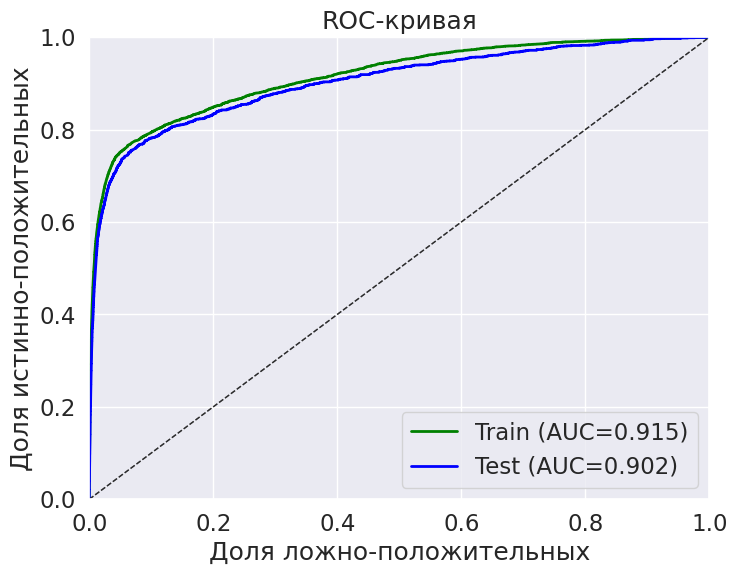

In [72]:
#площадь под ROC, расчет AUC, KS в train и test
def check_train_test_auc(x_train,y_train,x_test,y_test):
    from sklearn.linear_model import LogisticRegression
    lr1 = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.03, 1: 0.97})
    lr1.fit(x_train, y_train)
    pred_train = lr1.predict_proba(x_train)[:, 1]
    pred_test = lr1.predict_proba(x_test)[:, 1]
    print('train KS:', KS(pred_train, y_train))
    print('train AUC:', AUC(pred_train, y_train))
    print('test KS:', KS(pred_test, y_test))
    print('test AUC:', AUC(pred_test, y_test))
    #Рисуем обе ROC-кривые на одном графике
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_roc_curve_from_proba(y_train, pred_train, label='Train', color='green', ax=ax)
    plot_roc_curve_from_proba(y_test, pred_test, label='Test', color='blue', ax=ax)
    plt.show()
#train & test
check_train_test_auc(x_train = train_woe_with, y_train=y_train1,
                     x_test = test_woe_with, y_test = y_test1)

In [73]:
#просмотр intercept и коэффициентов логистической регрессии
model = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.03, 1: 0.97}, max_iter=300)
model.fit(train_woe_with, y_train1)
coefficients = np.append(model.intercept_, model.coef_)
print('Coefficients', coefficients)

Coefficients [-0.02598245  0.60301882  0.16779843  0.63270136  0.78963765  0.18558147
  0.623304    0.10779534  0.15747222  0.4793649   0.16548104  0.25158892
  0.40993746  0.42695894  0.98273337  0.94865945]


In [74]:
#запись переменных, использующихся в модели в новую переменную features_use
features_use = train_woe_with.columns.values.tolist()
features_use

['gender_nameRu',
 'LastApprovedOfferSet_Payment',
 'CBFactPmtsParametrSet',
 'AgeParametrSet',
 'PoVClient_ClientCountWithoutOverduePay',
 'CBMaxOverdueParametrSet',
 'CBCreditHistoryFromServParametrSet',
 'PKB_REQ_360DAY',
 'SUM_OSTATOK',
 'MAX_OUSTAND_DAY_CNT',
 'CNT_DAY_GR_0_Sum',
 'educationtypedmparse2',
 'low_rod_income',
 'KDN',
 'pd_cat']

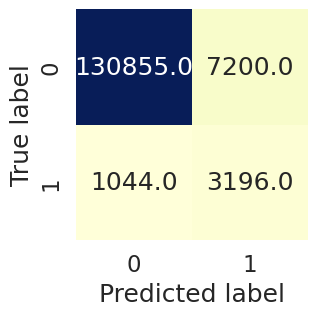

In [75]:
#матрица ошибок в обучающем датасете 
model = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.03, 1: 0.97}, max_iter=300)
model.fit(train_woe_with, y_train1)
y_pred_train1 = cross_val_predict(model, train_woe_with, y_train1, cv=3)
scores(y_pred_train1, y_train1)
#визуализация матрицы ошибок в обучающем датасете
plot_conf_mat(y_train1, y_pred_train1)

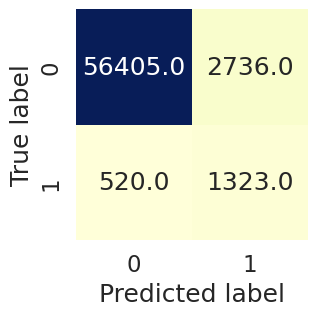

In [76]:
#матрица ошибок в тестовом датасете 
model = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.05, 1: 0.95}, max_iter=300)
model.fit(test_woe_with, y_test1)
y_pred_test1 = cross_val_predict(model, test_woe_with, y_test1, cv=3)
scores(y_test1, y_pred_test1)
#визуализация матрицы ошибок в тестовом датасете
plot_conf_mat(y_test1, y_pred_test1)

In [77]:
#вывод classification report для тренировочного датасета
print("Classification Report:")
print(classification_report(y_train1, y_pred_train1))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    138055
           1       0.31      0.75      0.44      4240

    accuracy                           0.94    142295
   macro avg       0.65      0.85      0.70    142295
weighted avg       0.97      0.94      0.95    142295



In [78]:
#вывод classification report для тестового датасета
print("Classification Report:")
print(classification_report(y_test1, y_pred_test1))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     59141
           1       0.33      0.72      0.45      1843

    accuracy                           0.95     60984
   macro avg       0.66      0.84      0.71     60984
weighted avg       0.97      0.95      0.96     60984



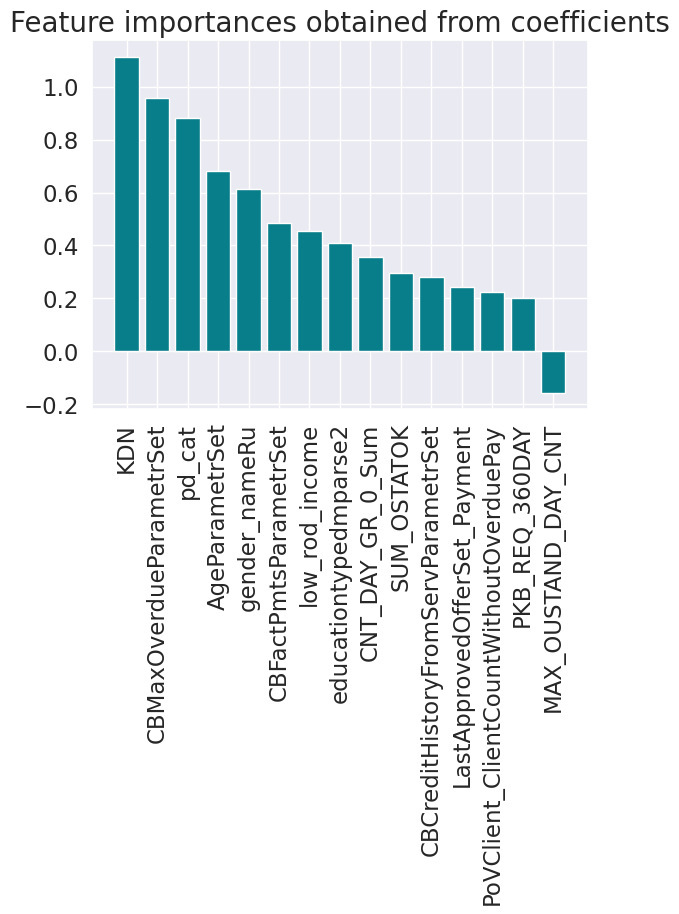

In [79]:
#расчет важности переменных, полученных из коэффициентов логистической регрессии
importances = pd.DataFrame(data={
    'Attribute': train_woe_with.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
#график важности переменных по коэффициентам логист. регрессии
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [97]:
####Validation Ensemble with LR

In [84]:
#заменяю inf и -inf средним значением:
def replace_inf_with_mean(df):
    float64_columns = df.select_dtypes(include = ['float64']).columns
    for col in float64_columns:
        df[col].replace([np.inf, -np.inf], 0, inplace = True)
replace_inf_with_mean(data)
#заменяю пустые значения
def replace_na(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            if df[col].isnull().any():
                df[col].fillna(0, inplace = True)
        elif df[col].dtype == 'object':
            if df[col].isnull().any():
                df[col].fillna('None', inplace = True)
replace_na(data)
#Выделяю зависимую переменную
X_valid = dataensvalid.drop('NPL91_EVER', axis = 1)
y_valid = dataensvalid['NPL91_EVER']
#Разделяю датасет без зависимой переменной на числовые и нечисловые переменные: 
numeric_df = X_valid.select_dtypes(include=[np.number])
object_df = X_valid.select_dtypes(include=[object])

numeric_df = numeric_df.reset_index(drop=True)

object_df = object_df.reset_index(drop=True)
object_df = object_df.astype(str)
#Кодирую категориальные столбцы
label_encoders = {}
for column in object_df.columns:
    le = LabelEncoder()
    object_df[column] = le.fit_transform(object_df[column])
    label_encoders[column] = le
#Масштабирую числовые столбцы
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
#Объедяю масштабированные числовые столбцы и закодированные категориальные столбцы
final_X_valid = pd.concat([scaled_numeric_df, object_df], axis=1)

In [85]:
#Разделяю датасет на трейн и тестовые выборки
y_valid = dataensvalid['NPL91_EVER']
#Бинирование данных c разделением пустых значений:
final_X_valid = combinerens.transform(final_X_valid)
#трансформация тренировочного датасета
#X_train_wt = tens.fit_transform(X=final_X_valid, y=y_valid)
#Загрузка моделей и прогнозирование на основе новых данных
def load_and_predict(new_data):
    lgbm_pred = lgbm.predict_proba(new_data[lgbm_top_features])[:, 1]
    xgb_pred = xgb.predict_proba(new_data[xgb_top_features])[:, 1]
    catboost_pred = catboost.predict_proba(new_data[catboost_top_features])[:, 1]
    #Объединение прогнозов
    stacked_probabilities = (lgbm_weight * lgbm_pred + xgb_weight * xgb_pred + catboost_weight * catboost_pred)
    return stacked_probabilities

#Получаем вероятности (probabilities of default, pd) 
stacked_probabilities_valid = load_and_predict(final_X_valid)
#Преобразуем массив вероятностей в dataFrame для дальнейшего анализа
stacked_valid_df = pd.DataFrame(stacked_probabilities_valid)
#Задаём имя столбца с вероятностями дефолта
stacked_valid_df.columns = ['pd']

#Функция для категоризации вероятности дефолта (pd) по заданным диапазонам
def compute_pd(stacked_valid_df):    
    if 0 <= stacked_valid_df['pd'] <= 0.1:
        return '0-0.1'
    elif 0.1 < stacked_valid_df['pd'] <= 0.2:
        return '0.11-0.2'
    elif 0.2 < stacked_valid_df['pd'] <= 0.3:
        return '0.21-0.3'
    elif 0.3 < stacked_valid_df['pd'] <= 0.4:
        return '0.31-0.4'
    elif 0.4 < stacked_valid_df['pd'] <= 0.5:
        return '0.41-0.5'
    elif stacked_valid_df['pd'] > 0.5:
        return '>0.5'
    else:
        return '>0.5'
stacked_valid_df['pd_cat'] = stacked_valid_df.apply(compute_pd, axis = 1)
stacked_valid_df = stacked_valid_df.drop(['pd'], axis=1)

train KS: 0.4584429867055549
train AUC: 0.803006421656211


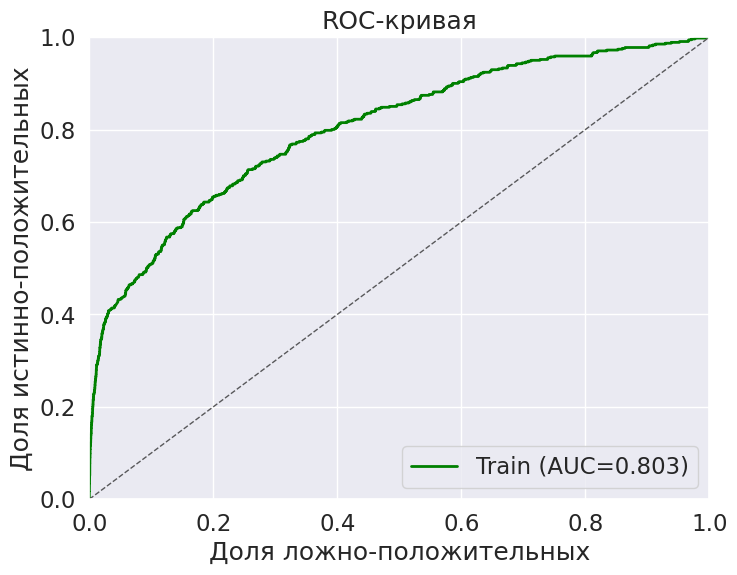

In [86]:
#соединение train_woe с логистической регрессии с xgb_cat
df1 = val_bin1.reset_index(drop=True)
df2 = stacked_valid_df.reset_index(drop=True)
val_bin_with = pd.concat([df1, df2], axis=1)

#трансформирование в WOE
t=toad.transform.WOETransformer()
#трансформация тренировочного датасета
valid_woe_with = t.fit_transform(X=val_bin_with, y=y_valid)


#площадь под ROC, расчет AUC, KS в train и test
def check_train_test_auc(x_train,y_train):
    from sklearn.linear_model import LogisticRegression
    lr1 = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.03, 1: 0.97})
    lr1.fit(x_train, y_train)
    pred_train = lr1.predict_proba(x_train)[:, 1]
    print('train KS:', KS(pred_train, y_train))
    print('train AUC:', AUC(pred_train, y_train))
    #Рисуем обе ROC-кривые на одном графике
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_roc_curve_from_proba(y_train, pred_train, label='Train', color='green', ax=ax)
    plt.show()
#train & test
check_train_test_auc(x_train = valid_woe_with, y_train=y_valid)

In [87]:
#просмотр intercept и коэффициентов логистической регрессии
model = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.03, 1: 0.97}, max_iter=300)
model.fit(valid_woe_with, y_valid)
coefficients = np.append(model.intercept_, model.coef_)
print('Coefficients', coefficients)

Coefficients [-0.18610278  0.37580304  0.47601784  0.46728692  0.70199796  0.14514877
  0.81317828  0.66126391  0.56638218 -0.36997013  0.12717213 -0.31735714
  0.71157851  0.45383854  0.55045658  0.93944014]


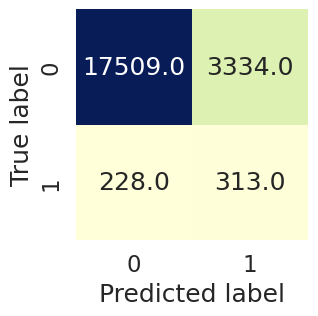

In [88]:
#матрица ошибок в обучающем датасете 
model = LogisticRegression(random_state=42, C= 1, penalty= 'l2',solver= 'sag', class_weight={0: 0.03, 1: 0.97}, max_iter=300)
model.fit(valid_woe_with, y_valid)
y_pred_valid1 = cross_val_predict(model, valid_woe_with, y_valid, cv=3)
scores(y_pred_valid1, y_valid)
#визуализация матрицы ошибок в обучающем датасете
plot_conf_mat(y_valid, y_pred_valid1)

In [89]:
#вывод classification report для тренировочного датасета
print("Classification Report:")
print(classification_report(y_valid, y_pred_valid1))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     20843
           1       0.09      0.58      0.15       541

    accuracy                           0.83     21384
   macro avg       0.54      0.71      0.53     21384
weighted avg       0.96      0.83      0.89     21384

